# Ensemble Model Training - Simplified Single-Branch Models

This notebook trains separate simplified CNN models for each feature type and then creates an ensemble.

In [1]:
from datetime import datetime
import os
import json
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.utils import to_categorical, Sequence
from keras.models import Model
from keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from modules.PostgresDBHandler import PostgresDBHandler

2025-07-07 10:23:21.299207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Configuration
dbParams = {
    "dbname": "mydatabase",
    "user": "myuser",
    "password": "mypassword",
    "host": "postgres_server",
    "port": "5432",
}
EPOCHS = 200
BATCH_SIZE = 32
KFOLD_SPLITS = 5
FIXED_LENGTH = 128

# Feature types to train models for
FEATURE_TYPES = [
    'mel_spectrogram', 'mfcc', 'chromagram', 'spectral_contrast',
    'tonnetz', 'constant_q', 'cqt', 'stft', 'harmonic_percussive', 'onset_strength'
]

# Feature shapes for each type
FEATURE_SHAPES = {
    'mel_spectrogram': (64, 128),
    'mfcc': (8, 128),
    'chromagram': (8, 128),
    'spectral_contrast': (3, 128),
    'tonnetz': (6, 128),
    'constant_q': (42, 128),
    'cqt': (42, 128),
    'stft': (512, 128),
    'harmonic_percussive': (1025, 128),
    'onset_strength': (1, 128)
}
# GPU configuration
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Number of available GPUs: {len(gpus)}")
    except RuntimeError as e:
        print(e)

Number of available GPUs: 1


2025-07-07 10:23:22.288928: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-07-07 10:23:22.289585: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-07-07 10:23:22.368838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:23:22.370545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUPER computeCapability: 8.9
coreClock: 2.61GHz coreCount: 80 deviceMemorySize: 15.59GiB deviceMemoryBandwidth: 685.51GiB/s
2025-07-07 10:23:22.370554: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-07-07 10:23:22.371580: I tensorflow/stream_executor/platf

In [3]:
# Initialize database connection
db = PostgresDBHandler(**dbParams)
db.connect()

# Get instrument mappings
instruments_mappings = db.get_mappings_instruments()
num_classes = len(instruments_mappings)
print(f"Number of instrument classes: {num_classes}")
print("Instruments:", instruments_mappings['name'].tolist())

db.close()

Number of instrument classes: 9
Instruments: ['oboe', 'sax', 'cello', 'bass', 'clarinet', 'piccolo', 'violin', 'flute', 'trumpet']


In [4]:
class SingleFeatureDataGenerator(Sequence):
    def __init__(self, df, feature_type, label_encoder, batch_size=32, shuffle=True):
        self.df = df.copy()  # Just to be safe
        self.feature_type = feature_type
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.label_encoder = label_encoder

        # Transform labels using the external encoder (DON'T fit again!)
        self.df['instrumentID_encoded'] = self.label_encoder.transform(self.df['instrumentID'])
        self.num_classes = len(self.label_encoder.classes_)
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        batch_df = self.df.iloc[indices]
        
        X = []
        y = []
        
        for _, row in batch_df.iterrows():
            feature_data = np.load(row['featurePath'])
            X.append(feature_data)
            y.append(row['instrumentID_encoded'])
        
        X = np.expand_dims(np.array(X), -1)
        y = to_categorical(y, num_classes=self.num_classes)
        
        return X, y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def get_labels(self):
        return self.df.iloc[self.indices]['instrumentID_encoded'].values

In [5]:
def create_simple_model(input_shape, num_classes, model_name="simple_cnn"):    
    """Create a simplified single-branch CNN model with reduced capacity."""
    input_layer = Input(shape=(*input_shape, 1), name=f"{model_name}_input")
    
    # Reduced number of filters and layers compared to original
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)    
    x = Flatten()(x)
    
    # Reduced dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    
    # Smaller final dense layer
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    output = Dense(num_classes, activation='softmax', name=f"{model_name}_output")(x)
    
    model = Model(inputs=input_layer, outputs=output, name=model_name)
    return model

In [6]:
# Load data for each feature type
db = PostgresDBHandler(**dbParams)
db.connect()

# Get all processed IDs
processed_ids = db.get_all_processed_ids()
print(f"Total processed samples: {len(processed_ids)}")

# Create DataFrames for each feature type
df_dict = {}
for feature_type in FEATURE_TYPES:
    processed_data = db.get_processed_fit_data(processed_ids, feature_type)
    
    if processed_data:
        df = pd.DataFrame(processed_data)
        df_dict[feature_type] = df
        print(f"{feature_type}: {len(df)} samples")
    else:
        print(f"Warning: No data found for {feature_type}")

db.close()

# Filter to only include feature types with data
available_feature_types = list(df_dict.keys())
print(f"\nAvailable feature types: {available_feature_types}")

Total processed samples: 9000
mel_spectrogram: 900 samples
mfcc: 900 samples
chromagram: 900 samples
spectral_contrast: 900 samples
tonnetz: 900 samples
constant_q: 900 samples
cqt: 900 samples
stft: 900 samples
harmonic_percussive: 900 samples
onset_strength: 900 samples

Available feature types: ['mel_spectrogram', 'mfcc', 'chromagram', 'spectral_contrast', 'tonnetz', 'constant_q', 'cqt', 'stft', 'harmonic_percussive', 'onset_strength']


Feature Types:   0%|          | 0/10 [00:00<?, ?it/s]


Training model for mel_spectrogram


mel_spectrogram Folds:   0%|          | 0/5 [00:00<?, ?it/s]


--- Fold 1/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [3. 5. 3. 3. 4. 3. 5. 2. 4.]


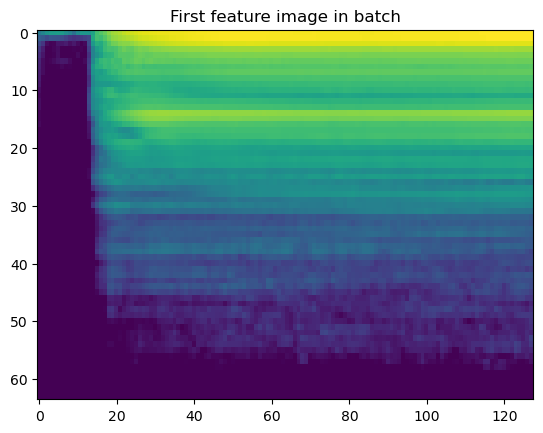

First label (one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0.]
First label (class index): 3
Label distribution in train_df: instrumentID
4    71
2    71
6    68
5    67
9    66
1    65
3    60
7    56
8    52
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False


2025-07-07 10:24:10.279652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-07 10:24:10.280188: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-07-07 10:24:10.280355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:24:10.282771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUPER computeCapability: 8.9
coreClock: 2.61GHz coreCount: 80 deviceMemorySize: 15.59GiB deviceMemoryBand

Epoch 1/200


2025-07-07 10:27:47.439875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-07-07 10:28:41.537289: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [ ]:
# Training results storage
all_results = {}
all_models = {}

# Fit on the full dataset
global_label_encoder = LabelEncoder()
global_label_encoder.fit(df['instrumentID'])  # Use original labels


# Train individual models for each feature type
for feature_type in tqdm(available_feature_types, desc = "Feature Types"):
    print(f"\n{'='*50}")
    print(f"Training model for {feature_type}")
    print(f"{'='*50}")
    
    df = df_dict[feature_type]
    input_shape = FEATURE_SHAPES[feature_type]
    
    # Initialize results storage for this feature type
    feature_results = {
        'accuracy_list': [],
        'loss_list': [],
        'classification_reports': [],
        'confusion_matrices': [],
        'histories': [],
        'models': []
    }
    
    # Cross-validation
    kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=42)
    
    for fold, (train_idx, test_idx) in enumerate(tqdm(list(kf.split(df)), desc = f"{feature_type} Folds")):
        print(f"\n--- Fold {fold + 1}/{KFOLD_SPLITS} ---")
        
        # Split data
        train_df = df.iloc[train_idx].reset_index(drop=True)
        test_df = df.iloc[test_idx].reset_index(drop=True)
        
        # Further split training data
        train_indices, val_indices = train_test_split(
            np.arange(len(train_df)), test_size=0.2, random_state=42
        )
        
        val_df = train_df.iloc[val_indices].reset_index(drop=True)
        train_df = train_df.iloc[train_indices].reset_index(drop=True)
        
        
        # Create data generators
        train_generator = SingleFeatureDataGenerator(train_df, feature_type, label_encoder=global_label_encoder)
        val_generator = SingleFeatureDataGenerator(val_df, feature_type, label_encoder=global_label_encoder)
        test_generator = SingleFeatureDataGenerator(test_df, feature_type, label_encoder=global_label_encoder)
        
        
        # --- DEBUG: Inspect a batch from the generator ---
        X, y = train_generator[0]
        print("X shape:", X.shape, "y shape:", y.shape)
        print("X min/max:", np.min(X), np.max(X))
        print("y (class distribution in batch):", np.sum(y, axis=0))
        plt.imshow(X[0, :, :, 0], aspect='auto')
        plt.title("First feature image in batch")
        plt.show()
        print("First label (one-hot):", y[0])
        print("First label (class index):", np.argmax(y[0]))
        # --- END DEBUG ---


        # --- DEBUG: Check label distribution in training set ---
        print("Label distribution in train_df:", train_df['instrumentID'].value_counts())
        print("Any NaNs in X?", np.isnan(X).any())
        print("All X values the same?", np.all(X == X.flat[0]))
        # --- END DEBUG ---
        
        # Create and compile model
        model = create_simple_model(input_shape, num_classes, f"{feature_type}_model")
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )
        
        # Early stopping
        early_stopping = EarlyStopping(
            monitor="val_loss", patience=40, restore_best_weights=True
        )
        
        # Train the model
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=EPOCHS,
            callbacks=[early_stopping],
            verbose=1
        )
        
        feature_results['histories'].append(history.history)
        
        # Evaluate the model
        loss, accuracy = model.evaluate(test_generator, verbose=0)
        feature_results['accuracy_list'].append(accuracy)
        feature_results['loss_list'].append(loss)
        
        print(f"Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
        
        # Predict and generate reports
        y_pred = model.predict(test_generator, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = test_generator.get_labels()
        
        # Classification report
        report = classification_report(y_true, y_pred_classes, output_dict=True)
        feature_results['classification_reports'].append(report)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred_classes).tolist()
        feature_results['confusion_matrices'].append(conf_matrix)
        
        # Save the best model (last one for now)
        feature_results['models'].append(model)
    
    # Store results for this feature type
    all_results[feature_type] = feature_results
    all_models[feature_type] = feature_results['models'][-1]  # Save the last model
    
    # Print summary for this feature type
    mean_acc = np.mean(feature_results['accuracy_list'])
    std_acc = np.std(feature_results['accuracy_list'])
    print(f"\n{feature_type} - Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

Feature Types:  60%
 6/10 [16:15<05:12, 78.15s/it]


==================================================
Training model for mel_spectrogram
==================================================

mel_spectrogram Folds: 100%
 5/5 [13:23<00:00, 73.60s/it]


--- Fold 1/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [3. 5. 3. 3. 4. 3. 5. 2. 4.]

First label (one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0.]
First label (class index): 3
Label distribution in train_df: instrumentID
4    71
2    71
6    68
5    67
9    66
1    65
3    60
7    56
8    52
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False

2025-07-07 10:24:10.279652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-07 10:24:10.280188: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-07-07 10:24:10.280355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:24:10.282771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4080 SUPER computeCapability: 8.9
coreClock: 2.61GHz coreCount: 80 deviceMemorySize: 15.59GiB deviceMemoryBandwidth: 685.51GiB/s
2025-07-07 10:24:10.282784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-07-07 10:24:10.282803: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-07-07 10:24:10.282810: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2025-07-07 10:24:10.282817: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2025-07-07 10:24:10.282823: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcurand.so.10
2025-07-07 10:24:10.282829: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.10
2025-07-07 10:24:10.282836: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusparse.so.10
2025-07-07 10:24:10.282843: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2025-07-07 10:24:10.282890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:24:10.284198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:24:10.285824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1862] Adding visible gpu devices: 0
2025-07-07 10:24:10.286038: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-07-07 10:27:47.091515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-07-07 10:27:47.091529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2025-07-07 10:27:47.091533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2025-07-07 10:27:47.092006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:27:47.093012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:27:47.094191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-07 10:27:47.095154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1406] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14010 MB memory) -> physical GPU (device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9)
2025-07-07 10:27:47.153471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-07-07 10:27:47.154285: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4199990000 Hz

Epoch 1/200

2025-07-07 10:27:47.439875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-07-07 10:28:41.537289: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7

18/18 [==============================] - 552s 13ms/step - loss: 2.2435 - accuracy: 0.1077 - val_loss: 2.2014 - val_accuracy: 0.1181
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1004 - val_loss: 2.2029 - val_accuracy: 0.1181
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1952 - accuracy: 0.1177 - val_loss: 2.2066 - val_accuracy: 0.0556
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1168 - val_loss: 2.2099 - val_accuracy: 0.0556
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1975 - accuracy: 0.1052 - val_loss: 2.2133 - val_accuracy: 0.0556
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1403 - val_loss: 2.2142 - val_accuracy: 0.0556
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.1225 - val_loss: 2.2147 - val_accuracy: 0.0556
Epoch 8/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1920 - accuracy: 0.1347 - val_loss: 2.2152 - val_accuracy: 0.0556
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1947 - accuracy: 0.1459 - val_loss: 2.2171 - val_accuracy: 0.0556
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1992 - accuracy: 0.1039 - val_loss: 2.2166 - val_accuracy: 0.0556
Epoch 11/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1945 - accuracy: 0.1474 - val_loss: 2.2179 - val_accuracy: 0.0556
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1912 - accuracy: 0.1259 - val_loss: 2.2185 - val_accuracy: 0.0556
Epoch 13/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1940 - accuracy: 0.1227 - val_loss: 2.2181 - val_accuracy: 0.0556
Epoch 14/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1899 - accuracy: 0.1328 - val_loss: 2.2195 - val_accuracy: 0.0556
Epoch 15/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 0.1020 - val_loss: 2.2192 - val_accuracy: 0.0556
Epoch 16/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1943 - accuracy: 0.1262 - val_loss: 2.2187 - val_accuracy: 0.0556
Epoch 17/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1968 - accuracy: 0.1055 - val_loss: 2.2187 - val_accuracy: 0.0556
Epoch 18/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1924 - accuracy: 0.1090 - val_loss: 2.2211 - val_accuracy: 0.0556
Epoch 19/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1917 - accuracy: 0.1220 - val_loss: 2.2228 - val_accuracy: 0.0556
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1929 - accuracy: 0.1331 - val_loss: 2.2230 - val_accuracy: 0.0556
Epoch 21/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1988 - accuracy: 0.1121 - val_loss: 2.2215 - val_accuracy: 0.0556
Epoch 22/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1943 - accuracy: 0.1289 - val_loss: 2.2214 - val_accuracy: 0.0556
Epoch 23/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1244 - val_loss: 2.2213 - val_accuracy: 0.0556
Epoch 24/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1917 - accuracy: 0.0989 - val_loss: 2.2219 - val_accuracy: 0.0556
Epoch 25/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1926 - accuracy: 0.1161 - val_loss: 2.2217 - val_accuracy: 0.0556
Epoch 26/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1897 - accuracy: 0.1074 - val_loss: 2.2216 - val_accuracy: 0.0556
Epoch 27/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1904 - accuracy: 0.0952 - val_loss: 2.2206 - val_accuracy: 0.0556
Epoch 28/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1979 - accuracy: 0.1140 - val_loss: 2.2179 - val_accuracy: 0.0556
Epoch 29/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1930 - accuracy: 0.1044 - val_loss: 2.2185 - val_accuracy: 0.0694
Epoch 30/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1892 - accuracy: 0.1397 - val_loss: 2.2207 - val_accuracy: 0.0694
Epoch 31/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1927 - accuracy: 0.1157 - val_loss: 2.2216 - val_accuracy: 0.0694
Epoch 32/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1911 - accuracy: 0.1108 - val_loss: 2.2231 - val_accuracy: 0.0694
Epoch 33/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1980 - accuracy: 0.1097 - val_loss: 2.2211 - val_accuracy: 0.0694
Epoch 34/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1912 - accuracy: 0.0976 - val_loss: 2.2228 - val_accuracy: 0.0556
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1938 - accuracy: 0.1276 - val_loss: 2.2238 - val_accuracy: 0.0556
Epoch 36/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1978 - accuracy: 0.1037 - val_loss: 2.2231 - val_accuracy: 0.0694
Epoch 37/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1815 - accuracy: 0.1396 - val_loss: 2.2283 - val_accuracy: 0.0556
Epoch 38/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1929 - accuracy: 0.1161 - val_loss: 2.2278 - val_accuracy: 0.0694
Epoch 39/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1899 - accuracy: 0.1081 - val_loss: 2.2279 - val_accuracy: 0.0694
Epoch 40/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1955 - accuracy: 0.1132 - val_loss: 2.2256 - val_accuracy: 0.0556
Epoch 41/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1921 - accuracy: 0.0954 - val_loss: 2.2255 - val_accuracy: 0.0556
Accuracy: 0.0944, Loss: 2.1991

--- Fold 2/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [2. 4. 5. 3. 2. 4. 4. 3. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0.]
First label (class index): 6
Label distribution in train_df: instrumentID
6    69
3    69
1    69
7    66
4    65
2    62
9    62
8    60
5    54
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.1032 - val_loss: 2.1973 - val_accuracy: 0.1042
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1971 - accuracy: 0.1219 - val_loss: 2.1973 - val_accuracy: 0.1042
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1968 - accuracy: 0.1277 - val_loss: 2.1973 - val_accuracy: 0.1042
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1968 - accuracy: 0.1116 - val_loss: 2.1973 - val_accuracy: 0.0972
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1966 - accuracy: 0.1208 - val_loss: 2.1973 - val_accuracy: 0.0972
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.0907 - val_loss: 2.1973 - val_accuracy: 0.1042
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1972 - accuracy: 0.0954 - val_loss: 2.1975 - val_accuracy: 0.0972
Epoch 8/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1955 - accuracy: 0.1207 - val_loss: 2.1975 - val_accuracy: 0.1042
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1944 - accuracy: 0.1460 - val_loss: 2.1974 - val_accuracy: 0.1042
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1949 - accuracy: 0.1349 - val_loss: 2.1975 - val_accuracy: 0.0972
Epoch 11/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1962 - accuracy: 0.1274 - val_loss: 2.1976 - val_accuracy: 0.0972
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1963 - accuracy: 0.1145 - val_loss: 2.1976 - val_accuracy: 0.1042
Epoch 13/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1957 - accuracy: 0.1113 - val_loss: 2.1977 - val_accuracy: 0.0972
Epoch 14/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1955 - accuracy: 0.1149 - val_loss: 2.1977 - val_accuracy: 0.0972
Epoch 15/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1961 - accuracy: 0.1174 - val_loss: 2.1978 - val_accuracy: 0.0972
Epoch 16/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1181 - val_loss: 2.1979 - val_accuracy: 0.1042
Epoch 17/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1965 - accuracy: 0.1276 - val_loss: 2.1980 - val_accuracy: 0.0972
Epoch 18/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1948 - accuracy: 0.1132 - val_loss: 2.1980 - val_accuracy: 0.1042
Epoch 19/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1945 - accuracy: 0.1368 - val_loss: 2.1981 - val_accuracy: 0.0972
Epoch 20/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1971 - accuracy: 0.1203 - val_loss: 2.1981 - val_accuracy: 0.0972
Epoch 21/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1935 - accuracy: 0.1335 - val_loss: 2.1982 - val_accuracy: 0.0972
Epoch 22/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1163 - val_loss: 2.1981 - val_accuracy: 0.0972
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1964 - accuracy: 0.1198 - val_loss: 2.1982 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1039 - val_loss: 2.1982 - val_accuracy: 0.1042
Epoch 25/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1966 - accuracy: 0.1283 - val_loss: 2.1982 - val_accuracy: 0.0972
Epoch 26/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1215 - val_loss: 2.1984 - val_accuracy: 0.0972
Epoch 27/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 0.1216 - val_loss: 2.1983 - val_accuracy: 0.0972
Epoch 28/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1944 - accuracy: 0.1370 - val_loss: 2.1985 - val_accuracy: 0.0972
Epoch 29/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1908 - accuracy: 0.1419 - val_loss: 2.1987 - val_accuracy: 0.0972
Epoch 30/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1927 - accuracy: 0.1194 - val_loss: 2.1986 - val_accuracy: 0.0972
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1954 - accuracy: 0.1115 - val_loss: 2.1987 - val_accuracy: 0.0972
Epoch 32/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1028 - val_loss: 2.1988 - val_accuracy: 0.0972
Epoch 33/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1913 - accuracy: 0.1162 - val_loss: 2.1987 - val_accuracy: 0.0972
Epoch 34/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1917 - accuracy: 0.1362 - val_loss: 2.1988 - val_accuracy: 0.0972
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1929 - accuracy: 0.1149 - val_loss: 2.1988 - val_accuracy: 0.1250
Epoch 36/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 0.1019 - val_loss: 2.1988 - val_accuracy: 0.0972
Epoch 37/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1976 - accuracy: 0.1126 - val_loss: 2.1989 - val_accuracy: 0.0972
Epoch 38/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1924 - accuracy: 0.1284 - val_loss: 2.1989 - val_accuracy: 0.0972
Epoch 39/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1942 - accuracy: 0.1188 - val_loss: 2.1989 - val_accuracy: 0.0972
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1953 - accuracy: 0.1033 - val_loss: 2.1990 - val_accuracy: 0.1042
Epoch 41/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1963 - accuracy: 0.1141 - val_loss: 2.1990 - val_accuracy: 0.0972
Accuracy: 0.0889, Loss: 2.1979

--- Fold 3/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 3.8146973e-06
y (class distribution in batch): [2. 5. 2. 8. 4. 2. 4. 2. 3.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
First label (class index): 8
Label distribution in train_df: instrumentID
4    72
2    67
9    66
8    65
5    65
1    64
6    63
3    58
7    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.0995 - val_loss: 2.1973 - val_accuracy: 0.1111
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1066 - val_loss: 2.1975 - val_accuracy: 0.1250
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1975 - accuracy: 0.0798 - val_loss: 2.1976 - val_accuracy: 0.0972
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1280 - val_loss: 2.1977 - val_accuracy: 0.0972
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1962 - accuracy: 0.1367 - val_loss: 2.1979 - val_accuracy: 0.0972
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1968 - accuracy: 0.1232 - val_loss: 2.1981 - val_accuracy: 0.0972
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1971 - accuracy: 0.1039 - val_loss: 2.1982 - val_accuracy: 0.0972
Epoch 8/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1964 - accuracy: 0.1121 - val_loss: 2.1984 - val_accuracy: 0.0972
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1344 - val_loss: 2.1986 - val_accuracy: 0.0972
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1962 - accuracy: 0.1318 - val_loss: 2.1987 - val_accuracy: 0.0972
Epoch 11/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1964 - accuracy: 0.1348 - val_loss: 2.1990 - val_accuracy: 0.0972
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1955 - accuracy: 0.1193 - val_loss: 2.1991 - val_accuracy: 0.0972
Epoch 13/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1964 - accuracy: 0.1052 - val_loss: 2.1992 - val_accuracy: 0.0972
Epoch 14/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1952 - accuracy: 0.1446 - val_loss: 2.1995 - val_accuracy: 0.0972
Epoch 15/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1950 - accuracy: 0.1299 - val_loss: 2.1995 - val_accuracy: 0.0972
Epoch 16/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1941 - accuracy: 0.1390 - val_loss: 2.1998 - val_accuracy: 0.0972
Epoch 17/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1950 - accuracy: 0.1231 - val_loss: 2.1999 - val_accuracy: 0.0972
Epoch 18/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1946 - accuracy: 0.1299 - val_loss: 2.2000 - val_accuracy: 0.0972
Epoch 19/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.1414 - val_loss: 2.2002 - val_accuracy: 0.0972
Epoch 20/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1937 - accuracy: 0.1305 - val_loss: 2.2003 - val_accuracy: 0.0972
Epoch 21/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1113 - val_loss: 2.2004 - val_accuracy: 0.0972
Epoch 22/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1953 - accuracy: 0.1328 - val_loss: 2.2005 - val_accuracy: 0.0972
Epoch 23/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1952 - accuracy: 0.1400 - val_loss: 2.2006 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1984 - accuracy: 0.1084 - val_loss: 2.2006 - val_accuracy: 0.0972
Epoch 25/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1952 - accuracy: 0.1585 - val_loss: 2.2008 - val_accuracy: 0.0972
Epoch 26/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1965 - accuracy: 0.1216 - val_loss: 2.2010 - val_accuracy: 0.0972
Epoch 27/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1949 - accuracy: 0.1303 - val_loss: 2.2011 - val_accuracy: 0.0972
Epoch 28/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1351 - val_loss: 2.2012 - val_accuracy: 0.0972
Epoch 29/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1376 - val_loss: 2.2013 - val_accuracy: 0.0972
Epoch 30/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1957 - accuracy: 0.1214 - val_loss: 2.2015 - val_accuracy: 0.0972
Epoch 31/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1948 - accuracy: 0.1383 - val_loss: 2.2015 - val_accuracy: 0.0972
Epoch 32/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1965 - accuracy: 0.1328 - val_loss: 2.2015 - val_accuracy: 0.0972
Epoch 33/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1912 - accuracy: 0.1441 - val_loss: 2.2018 - val_accuracy: 0.0972
Epoch 34/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1974 - accuracy: 0.1051 - val_loss: 2.2019 - val_accuracy: 0.0972
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1934 - accuracy: 0.1412 - val_loss: 2.2019 - val_accuracy: 0.0972
Epoch 36/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1975 - accuracy: 0.1384 - val_loss: 2.2019 - val_accuracy: 0.0972
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1122 - val_loss: 2.2021 - val_accuracy: 0.0972
Epoch 38/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 0.1211 - val_loss: 2.2021 - val_accuracy: 0.0972
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1160 - val_loss: 2.2022 - val_accuracy: 0.0972
Epoch 40/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1928 - accuracy: 0.1468 - val_loss: 2.2024 - val_accuracy: 0.0972
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1975 - accuracy: 0.1170 - val_loss: 2.2023 - val_accuracy: 0.0972
Accuracy: 0.1056, Loss: 2.1977

--- Fold 4/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [4. 4. 3. 4. 4. 5. 6. 1. 1.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0.]
First label (class index): 6
Label distribution in train_df: instrumentID
2    69
7    68
1    66
3    66
8    65
5    62
4    61
6    61
9    58
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 15ms/step - loss: 2.3375 - accuracy: 0.1283 - val_loss: 2.1982 - val_accuracy: 0.0972
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1971 - accuracy: 0.1078 - val_loss: 2.1982 - val_accuracy: 0.0972
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1966 - accuracy: 0.1317 - val_loss: 2.1984 - val_accuracy: 0.0972
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1966 - accuracy: 0.1220 - val_loss: 2.1985 - val_accuracy: 0.0972
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1962 - accuracy: 0.1037 - val_loss: 2.1985 - val_accuracy: 0.1528
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1968 - accuracy: 0.1193 - val_loss: 2.1984 - val_accuracy: 0.1528
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1974 - accuracy: 0.1202 - val_loss: 2.1985 - val_accuracy: 0.1528
Epoch 8/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1961 - accuracy: 0.1096 - val_loss: 2.1982 - val_accuracy: 0.0694
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1971 - accuracy: 0.1077 - val_loss: 2.1982 - val_accuracy: 0.1528
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1357 - val_loss: 2.1983 - val_accuracy: 0.1528
Epoch 11/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1961 - accuracy: 0.1359 - val_loss: 2.1983 - val_accuracy: 0.0694
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1976 - accuracy: 0.0935 - val_loss: 2.1983 - val_accuracy: 0.1528
Epoch 13/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1977 - accuracy: 0.1239 - val_loss: 2.1981 - val_accuracy: 0.0694
Epoch 14/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1955 - accuracy: 0.1258 - val_loss: 2.1987 - val_accuracy: 0.1528
Epoch 15/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1964 - accuracy: 0.1063 - val_loss: 2.1991 - val_accuracy: 0.1528
Epoch 16/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.1025 - val_loss: 2.1994 - val_accuracy: 0.1528
Epoch 17/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1103 - val_loss: 2.1993 - val_accuracy: 0.1528
Epoch 18/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1946 - accuracy: 0.1430 - val_loss: 2.1992 - val_accuracy: 0.1528
Epoch 19/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.0871 - val_loss: 2.1990 - val_accuracy: 0.1528
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1953 - accuracy: 0.1182 - val_loss: 2.1993 - val_accuracy: 0.0694
Epoch 21/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.1350 - val_loss: 2.1993 - val_accuracy: 0.1528
Epoch 22/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.1274 - val_loss: 2.1993 - val_accuracy: 0.0694
Epoch 23/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1965 - accuracy: 0.1194 - val_loss: 2.1992 - val_accuracy: 0.1528
Epoch 24/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1994 - accuracy: 0.1185 - val_loss: 2.1990 - val_accuracy: 0.1528
Epoch 25/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1963 - accuracy: 0.1126 - val_loss: 2.1994 - val_accuracy: 0.1528
Epoch 26/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 0.1572 - val_loss: 2.1993 - val_accuracy: 0.0694
Epoch 27/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 0.1696 - val_loss: 2.1992 - val_accuracy: 0.0694
Epoch 28/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1949 - accuracy: 0.1374 - val_loss: 2.1996 - val_accuracy: 0.1528
Epoch 29/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1955 - accuracy: 0.0887 - val_loss: 2.1997 - val_accuracy: 0.0694
Epoch 30/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1952 - accuracy: 0.1262 - val_loss: 2.2000 - val_accuracy: 0.1528
Epoch 31/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1946 - accuracy: 0.1209 - val_loss: 2.2002 - val_accuracy: 0.1528
Epoch 32/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1957 - accuracy: 0.1038 - val_loss: 2.1998 - val_accuracy: 0.0694
Epoch 33/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1943 - accuracy: 0.1112 - val_loss: 2.1999 - val_accuracy: 0.1528
Epoch 34/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1975 - accuracy: 0.1141 - val_loss: 2.2000 - val_accuracy: 0.1528
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1039 - val_loss: 2.1996 - val_accuracy: 0.0694
Epoch 36/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1954 - accuracy: 0.1148 - val_loss: 2.1998 - val_accuracy: 0.0694
Epoch 37/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1967 - accuracy: 0.1359 - val_loss: 2.1996 - val_accuracy: 0.0694
Epoch 38/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1965 - accuracy: 0.1152 - val_loss: 2.1995 - val_accuracy: 0.0694
Epoch 39/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1952 - accuracy: 0.1303 - val_loss: 2.1999 - val_accuracy: 0.0694
Epoch 40/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1954 - accuracy: 0.1234 - val_loss: 2.1999 - val_accuracy: 0.0694
Epoch 41/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1970 - accuracy: 0.1084 - val_loss: 2.2000 - val_accuracy: 0.0694
Epoch 42/200
18/18 [==============================] - 0s 8ms/step - loss: 2.2022 - accuracy: 0.0937 - val_loss: 2.1997 - val_accuracy: 0.0694
Epoch 43/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1067 - val_loss: 2.1999 - val_accuracy: 0.0694
Epoch 44/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1149 - val_loss: 2.1996 - val_accuracy: 0.0694
Epoch 45/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1092 - val_loss: 2.1994 - val_accuracy: 0.0694
Epoch 46/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1970 - accuracy: 0.1206 - val_loss: 2.1997 - val_accuracy: 0.0694
Epoch 47/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1954 - accuracy: 0.1096 - val_loss: 2.1997 - val_accuracy: 0.0694
Epoch 48/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1971 - accuracy: 0.1100 - val_loss: 2.1997 - val_accuracy: 0.0694
Epoch 49/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1945 - accuracy: 0.1263 - val_loss: 2.2002 - val_accuracy: 0.0694
Epoch 50/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1943 - accuracy: 0.1231 - val_loss: 2.2004 - val_accuracy: 0.0694
Epoch 51/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1971 - accuracy: 0.1142 - val_loss: 2.1999 - val_accuracy: 0.0694
Epoch 52/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1952 - accuracy: 0.1263 - val_loss: 2.2017 - val_accuracy: 0.0694
Epoch 53/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.1287 - val_loss: 2.1997 - val_accuracy: 0.0694
Accuracy: 0.1167, Loss: 2.2002

--- Fold 5/5 ---
X shape: (32, 64, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [3. 4. 5. 3. 3. 6. 2. 3. 3.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 1. 0.]
First label (class index): 7
Label distribution in train_df: instrumentID
6    71
4    71
2    68
3    68
5    64
9    63
1    58
8    57
7    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.0953 - val_loss: 2.1976 - val_accuracy: 0.1181
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1970 - accuracy: 0.1041 - val_loss: 2.1981 - val_accuracy: 0.1181
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1964 - accuracy: 0.1335 - val_loss: 2.1986 - val_accuracy: 0.0903
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1962 - accuracy: 0.1391 - val_loss: 2.1990 - val_accuracy: 0.0903
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1957 - accuracy: 0.1387 - val_loss: 2.1995 - val_accuracy: 0.0903
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1961 - accuracy: 0.1316 - val_loss: 2.2000 - val_accuracy: 0.0903
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1943 - accuracy: 0.1398 - val_loss: 2.2004 - val_accuracy: 0.0903
Epoch 8/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1210 - val_loss: 2.2008 - val_accuracy: 0.0833
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1967 - accuracy: 0.1143 - val_loss: 2.2011 - val_accuracy: 0.0833
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1955 - accuracy: 0.1384 - val_loss: 2.2015 - val_accuracy: 0.0833
Epoch 11/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1948 - accuracy: 0.1269 - val_loss: 2.2020 - val_accuracy: 0.0903
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1961 - accuracy: 0.1063 - val_loss: 2.2023 - val_accuracy: 0.0833
Epoch 13/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1948 - accuracy: 0.1009 - val_loss: 2.2026 - val_accuracy: 0.0903
Epoch 14/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1939 - accuracy: 0.1080 - val_loss: 2.2031 - val_accuracy: 0.0833
Epoch 15/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1942 - accuracy: 0.1311 - val_loss: 2.2033 - val_accuracy: 0.0833
Epoch 16/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1922 - accuracy: 0.1415 - val_loss: 2.2038 - val_accuracy: 0.0833
Epoch 17/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1945 - accuracy: 0.1057 - val_loss: 2.2039 - val_accuracy: 0.0903
Epoch 18/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1171 - val_loss: 2.2042 - val_accuracy: 0.0833
Epoch 19/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1972 - accuracy: 0.0988 - val_loss: 2.2045 - val_accuracy: 0.0903
Epoch 20/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1943 - accuracy: 0.1236 - val_loss: 2.2049 - val_accuracy: 0.0833
Epoch 21/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1937 - accuracy: 0.1316 - val_loss: 2.2052 - val_accuracy: 0.0903
Epoch 22/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1930 - accuracy: 0.1388 - val_loss: 2.2055 - val_accuracy: 0.0903
Epoch 23/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1895 - accuracy: 0.1348 - val_loss: 2.2060 - val_accuracy: 0.0833
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1227 - val_loss: 2.2060 - val_accuracy: 0.0833
Epoch 25/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1899 - accuracy: 0.1478 - val_loss: 2.2064 - val_accuracy: 0.0833
Epoch 26/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1931 - accuracy: 0.1332 - val_loss: 2.2066 - val_accuracy: 0.0903
Epoch 27/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1935 - accuracy: 0.1307 - val_loss: 2.2068 - val_accuracy: 0.0903
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1174 - val_loss: 2.2070 - val_accuracy: 0.0903
Epoch 29/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1940 - accuracy: 0.1130 - val_loss: 2.2071 - val_accuracy: 0.0903
Epoch 30/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1894 - accuracy: 0.1374 - val_loss: 2.2074 - val_accuracy: 0.0903
Epoch 31/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1914 - accuracy: 0.1103 - val_loss: 2.2077 - val_accuracy: 0.0833
Epoch 32/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1943 - accuracy: 0.1120 - val_loss: 2.2079 - val_accuracy: 0.0903
Epoch 33/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1957 - accuracy: 0.1322 - val_loss: 2.2079 - val_accuracy: 0.0903
Epoch 34/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1921 - accuracy: 0.0912 - val_loss: 2.2082 - val_accuracy: 0.0903
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1939 - accuracy: 0.1209 - val_loss: 2.2083 - val_accuracy: 0.0833
Epoch 36/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1968 - accuracy: 0.1089 - val_loss: 2.2084 - val_accuracy: 0.0903
Epoch 37/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1929 - accuracy: 0.1321 - val_loss: 2.2087 - val_accuracy: 0.0903
Epoch 38/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1985 - accuracy: 0.1089 - val_loss: 2.2087 - val_accuracy: 0.0903
Epoch 39/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1972 - accuracy: 0.1073 - val_loss: 2.2090 - val_accuracy: 0.0903
Epoch 40/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1963 - accuracy: 0.0950 - val_loss: 2.2090 - val_accuracy: 0.0903
Epoch 41/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1100 - val_loss: 2.2092 - val_accuracy: 0.0833
Accuracy: 0.0833, Loss: 2.1979

mel_spectrogram - Mean Accuracy: 0.0978 ± 0.0120

==================================================
Training model for mfcc
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

mfcc Folds: 100%
 5/5 [00:31<00:00,  6.26s/it]


--- Fold 1/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: -609.31323 200.29572
y (class distribution in batch): [4. 5. 4. 1. 9. 1. 2. 3. 3.]

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 1. 0.]
First label (class index): 7
Label distribution in train_df: instrumentID
4    73
9    69
6    68
2    68
1    65
5    65
3    59
7    56
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.3862 - accuracy: 0.0965 - val_loss: 6.5070 - val_accuracy: 0.1111
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4938 - accuracy: 0.1089 - val_loss: 2.3230 - val_accuracy: 0.0625
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.5310 - accuracy: 0.0963 - val_loss: 2.6722 - val_accuracy: 0.0486
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3430 - accuracy: 0.0916 - val_loss: 2.2344 - val_accuracy: 0.0486
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3172 - accuracy: 0.1156 - val_loss: 2.3255 - val_accuracy: 0.0694
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3078 - accuracy: 0.1052 - val_loss: 2.1851 - val_accuracy: 0.1389
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3521 - accuracy: 0.0940 - val_loss: 2.2444 - val_accuracy: 0.1181
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3382 - accuracy: 0.1032 - val_loss: 2.2516 - val_accuracy: 0.0833
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3026 - accuracy: 0.1273 - val_loss: 2.2207 - val_accuracy: 0.1250
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2967 - accuracy: 0.1200 - val_loss: 2.2014 - val_accuracy: 0.1181
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3369 - accuracy: 0.0943 - val_loss: 2.2052 - val_accuracy: 0.1319
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3326 - accuracy: 0.0771 - val_loss: 2.1955 - val_accuracy: 0.1111
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2798 - accuracy: 0.1426 - val_loss: 2.2020 - val_accuracy: 0.0694
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2923 - accuracy: 0.1091 - val_loss: 2.2654 - val_accuracy: 0.1181
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2703 - accuracy: 0.1434 - val_loss: 2.2134 - val_accuracy: 0.1528
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2678 - accuracy: 0.1148 - val_loss: 2.2171 - val_accuracy: 0.1250
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2528 - accuracy: 0.1388 - val_loss: 593.2265 - val_accuracy: 0.1042
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2634 - accuracy: 0.1110 - val_loss: 2.2043 - val_accuracy: 0.1250
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2702 - accuracy: 0.1105 - val_loss: 2.2048 - val_accuracy: 0.1250
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2781 - accuracy: 0.1090 - val_loss: 2.2051 - val_accuracy: 0.1250
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2110 - accuracy: 0.1481 - val_loss: 2.2054 - val_accuracy: 0.1250
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2632 - accuracy: 0.1028 - val_loss: 2.2053 - val_accuracy: 0.1250
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2929 - accuracy: 0.1003 - val_loss: 2.2053 - val_accuracy: 0.1250
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2479 - accuracy: 0.1291 - val_loss: 2.2056 - val_accuracy: 0.1250
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2189 - accuracy: 0.1297 - val_loss: 2.2056 - val_accuracy: 0.1250
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2847 - accuracy: 0.1209 - val_loss: 2.2059 - val_accuracy: 0.1250
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2629 - accuracy: 0.1519 - val_loss: 2.2056 - val_accuracy: 0.1250
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2140 - accuracy: 0.1579 - val_loss: 2.2060 - val_accuracy: 0.1250
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2249 - accuracy: 0.1041 - val_loss: 2.2060 - val_accuracy: 0.1250
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2186 - accuracy: 0.1464 - val_loss: 2.2061 - val_accuracy: 0.1250
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2123 - accuracy: 0.1360 - val_loss: 2.2063 - val_accuracy: 0.1250
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2555 - accuracy: 0.1168 - val_loss: 2.2061 - val_accuracy: 0.1250
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2263 - accuracy: 0.0957 - val_loss: 2.2064 - val_accuracy: 0.1250
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2048 - accuracy: 0.1291 - val_loss: 2.2066 - val_accuracy: 0.1250
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2094 - accuracy: 0.1306 - val_loss: 2.2067 - val_accuracy: 0.1250
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2154 - accuracy: 0.1055 - val_loss: 2.2070 - val_accuracy: 0.1250
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2382 - accuracy: 0.0919 - val_loss: 2.2073 - val_accuracy: 0.1250
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2271 - accuracy: 0.1088 - val_loss: 2.2075 - val_accuracy: 0.1250
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2077 - accuracy: 0.1175 - val_loss: 2.2081 - val_accuracy: 0.1250
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2120 - accuracy: 0.1301 - val_loss: 2.2079 - val_accuracy: 0.1250
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2241 - accuracy: 0.1029 - val_loss: 2.2082 - val_accuracy: 0.1181
Epoch 42/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2285 - accuracy: 0.0821 - val_loss: 2.2090 - val_accuracy: 0.1250
Epoch 43/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2418 - accuracy: 0.1092 - val_loss: 2.2095 - val_accuracy: 0.1250
Epoch 44/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1404 - val_loss: 2.2098 - val_accuracy: 0.1250
Epoch 45/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2041 - accuracy: 0.0949 - val_loss: 2.2100 - val_accuracy: 0.0486
Epoch 46/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2136 - accuracy: 0.1055 - val_loss: 2.2103 - val_accuracy: 0.0486
Accuracy: 0.0833, Loss: 4.0803

--- Fold 2/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: -596.6504 187.85594
y (class distribution in batch): [6. 4. 1. 3. 3. 5. 4. 4. 2.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 1. 0. 0. 0. 0. 0. 0. 0.]
First label (class index): 1
Label distribution in train_df: instrumentID
6    69
1    69
4    67
3    67
7    65
9    65
2    62
8    62
5    50
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 10ms/step - loss: 2.1973 - accuracy: 0.0951 - val_loss: 2.1976 - val_accuracy: 0.0972
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1238 - val_loss: 2.1977 - val_accuracy: 0.0972
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1044 - val_loss: 2.1978 - val_accuracy: 0.0972
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1080 - val_loss: 2.1978 - val_accuracy: 0.0972
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1960 - accuracy: 0.1258 - val_loss: 2.1981 - val_accuracy: 0.0972
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1163 - val_loss: 2.1981 - val_accuracy: 0.0972
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1197 - val_loss: 2.1982 - val_accuracy: 0.0972
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1227 - val_loss: 2.1983 - val_accuracy: 0.0972
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1121 - val_loss: 2.1984 - val_accuracy: 0.0972
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1449 - val_loss: 2.1985 - val_accuracy: 0.0972
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1093 - val_loss: 2.1987 - val_accuracy: 0.0972
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1127 - val_loss: 2.1988 - val_accuracy: 0.0972
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1102 - val_loss: 2.1990 - val_accuracy: 0.0972
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1142 - val_loss: 2.1990 - val_accuracy: 0.0972
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1042 - val_loss: 2.1992 - val_accuracy: 0.0972
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1965 - accuracy: 0.1119 - val_loss: 2.1992 - val_accuracy: 0.0972
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1095 - val_loss: 2.1996 - val_accuracy: 0.0972
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1935 - accuracy: 0.1368 - val_loss: 2.1995 - val_accuracy: 0.0972
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1930 - accuracy: 0.1296 - val_loss: 2.1998 - val_accuracy: 0.0972
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1242 - val_loss: 2.1999 - val_accuracy: 0.0972
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1062 - val_loss: 2.1998 - val_accuracy: 0.0972
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1919 - accuracy: 0.1391 - val_loss: 2.2001 - val_accuracy: 0.0972
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1936 - accuracy: 0.1151 - val_loss: 2.2002 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1962 - accuracy: 0.1155 - val_loss: 2.2002 - val_accuracy: 0.0972
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1946 - accuracy: 0.1255 - val_loss: 2.2004 - val_accuracy: 0.0972
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1919 - accuracy: 0.1120 - val_loss: 2.2005 - val_accuracy: 0.0972
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1088 - val_loss: 2.2007 - val_accuracy: 0.0972
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1943 - accuracy: 0.0995 - val_loss: 2.2007 - val_accuracy: 0.1250
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1348 - val_loss: 2.2008 - val_accuracy: 0.0972
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1185 - val_loss: 2.2009 - val_accuracy: 0.0972
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1931 - accuracy: 0.1440 - val_loss: 2.2010 - val_accuracy: 0.0972
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1944 - accuracy: 0.1245 - val_loss: 2.2011 - val_accuracy: 0.0972
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1924 - accuracy: 0.1211 - val_loss: 2.2014 - val_accuracy: 0.0972
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1911 - accuracy: 0.1262 - val_loss: 2.2014 - val_accuracy: 0.0972
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1940 - accuracy: 0.1288 - val_loss: 2.2014 - val_accuracy: 0.0972
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1924 - accuracy: 0.1211 - val_loss: 2.2014 - val_accuracy: 0.1250
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1223 - val_loss: 2.2017 - val_accuracy: 0.0972
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1936 - accuracy: 0.1100 - val_loss: 2.2016 - val_accuracy: 0.0972
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1322 - val_loss: 2.2016 - val_accuracy: 0.0972
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1964 - accuracy: 0.1185 - val_loss: 2.2018 - val_accuracy: 0.0972
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1924 - accuracy: 0.1339 - val_loss: 2.2018 - val_accuracy: 0.0972
Accuracy: 0.0944, Loss: 2.1977

--- Fold 3/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: -558.8268 189.6047
y (class distribution in batch): [5. 5. 4. 4. 5. 1. 4. 2. 2.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0.]
First label (class index): 3
Label distribution in train_df: instrumentID
4    74
9    66
2    66
5    65
8    64
1    64
6    63
7    58
3    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 10ms/step - loss: 2.1973 - accuracy: 0.1035 - val_loss: 2.1976 - val_accuracy: 0.0903
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1972 - accuracy: 0.1107 - val_loss: 2.1979 - val_accuracy: 0.0903
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1418 - val_loss: 2.1983 - val_accuracy: 0.0903
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1967 - accuracy: 0.1227 - val_loss: 2.1986 - val_accuracy: 0.0903
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1472 - val_loss: 2.1989 - val_accuracy: 0.0903
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1240 - val_loss: 2.1992 - val_accuracy: 0.0903
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1969 - accuracy: 0.1255 - val_loss: 2.1992 - val_accuracy: 0.0903
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1084 - val_loss: 2.1996 - val_accuracy: 0.0903
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1972 - accuracy: 0.1110 - val_loss: 2.1998 - val_accuracy: 0.0903
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1165 - val_loss: 2.2001 - val_accuracy: 0.0903
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1044 - val_loss: 2.2003 - val_accuracy: 0.0903
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1956 - accuracy: 0.1274 - val_loss: 2.2005 - val_accuracy: 0.0903
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1298 - val_loss: 2.2009 - val_accuracy: 0.0903
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1960 - accuracy: 0.1192 - val_loss: 2.2011 - val_accuracy: 0.0903
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1936 - accuracy: 0.1494 - val_loss: 2.2013 - val_accuracy: 0.0903
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1409 - val_loss: 2.2015 - val_accuracy: 0.0903
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1250 - val_loss: 2.2017 - val_accuracy: 0.0903
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1977 - accuracy: 0.1145 - val_loss: 2.2019 - val_accuracy: 0.0903
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1978 - accuracy: 0.1208 - val_loss: 2.2021 - val_accuracy: 0.0903
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1159 - val_loss: 2.2024 - val_accuracy: 0.0903
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1946 - accuracy: 0.1197 - val_loss: 2.2025 - val_accuracy: 0.0903
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1962 - accuracy: 0.1241 - val_loss: 2.2026 - val_accuracy: 0.0903
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1954 - accuracy: 0.1207 - val_loss: 2.2029 - val_accuracy: 0.0903
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1330 - val_loss: 2.2031 - val_accuracy: 0.0903
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1318 - val_loss: 2.2032 - val_accuracy: 0.0903
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1385 - val_loss: 2.2033 - val_accuracy: 0.0903
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1956 - accuracy: 0.1218 - val_loss: 2.2035 - val_accuracy: 0.0903
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1954 - accuracy: 0.1124 - val_loss: 2.2037 - val_accuracy: 0.0903
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1335 - val_loss: 2.2038 - val_accuracy: 0.0903
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1946 - accuracy: 0.1109 - val_loss: 2.2040 - val_accuracy: 0.0903
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1939 - accuracy: 0.1152 - val_loss: 2.2042 - val_accuracy: 0.0903
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1068 - val_loss: 2.2043 - val_accuracy: 0.0903
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1935 - accuracy: 0.1176 - val_loss: 2.2044 - val_accuracy: 0.0903
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1975 - accuracy: 0.1151 - val_loss: 2.2044 - val_accuracy: 0.0903
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1978 - accuracy: 0.1159 - val_loss: 2.2045 - val_accuracy: 0.0903
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1213 - val_loss: 2.2046 - val_accuracy: 0.0903
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1905 - accuracy: 0.1460 - val_loss: 2.2050 - val_accuracy: 0.0903
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1940 - accuracy: 0.1278 - val_loss: 2.2051 - val_accuracy: 0.0903
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1986 - accuracy: 0.1115 - val_loss: 2.2051 - val_accuracy: 0.0903
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1364 - val_loss: 2.2053 - val_accuracy: 0.0903
Epoch 41/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1971 - accuracy: 0.1260 - val_loss: 2.2054 - val_accuracy: 0.0903
Accuracy: 0.0722, Loss: 2.1976

--- Fold 4/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: -560.6386 215.96014
y (class distribution in batch): [4. 4. 1. 2. 4. 4. 7. 5. 1.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 1. 0. 0. 0. 0. 0. 0.]
First label (class index): 2
Label distribution in train_df: instrumentID
2    70
7    66
1    66
5    66
3    66
8    63
6    61
9    59
4    59
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1832 - accuracy: 0.1458 - val_loss: 2.1979 - val_accuracy: 0.0625
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1348 - val_loss: 2.1981 - val_accuracy: 0.0625
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1020 - val_loss: 2.1990 - val_accuracy: 0.0625
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1253 - val_loss: 2.1987 - val_accuracy: 0.0625
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1985 - accuracy: 0.1126 - val_loss: 2.1979 - val_accuracy: 0.0625
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1956 - accuracy: 0.1293 - val_loss: 2.1998 - val_accuracy: 0.0625
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1972 - accuracy: 0.1141 - val_loss: 2.2000 - val_accuracy: 0.0625
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1977 - accuracy: 0.1069 - val_loss: 2.1998 - val_accuracy: 0.0625
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1185 - val_loss: 2.1997 - val_accuracy: 0.0625
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1190 - val_loss: 2.1996 - val_accuracy: 0.0625
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1965 - accuracy: 0.1271 - val_loss: 2.1996 - val_accuracy: 0.0625
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1154 - val_loss: 2.1996 - val_accuracy: 0.0625
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1154 - val_loss: 2.2000 - val_accuracy: 0.0625
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1986 - accuracy: 0.1008 - val_loss: 2.2004 - val_accuracy: 0.0625
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1973 - accuracy: 0.1074 - val_loss: 2.1996 - val_accuracy: 0.0625
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1973 - accuracy: 0.1167 - val_loss: 2.2000 - val_accuracy: 0.0625
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1977 - accuracy: 0.1352 - val_loss: 2.1989 - val_accuracy: 0.0625
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1256 - val_loss: 2.1996 - val_accuracy: 0.0625
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1943 - accuracy: 0.1324 - val_loss: 2.1999 - val_accuracy: 0.0625
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2002 - accuracy: 0.1040 - val_loss: 2.2001 - val_accuracy: 0.0625
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1953 - accuracy: 0.1170 - val_loss: 2.2000 - val_accuracy: 0.0625
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1998 - accuracy: 0.1231 - val_loss: 2.1999 - val_accuracy: 0.0625
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1917 - accuracy: 0.1319 - val_loss: 2.2013 - val_accuracy: 0.0625
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1926 - accuracy: 0.1486 - val_loss: 2.2011 - val_accuracy: 0.0625
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2000 - accuracy: 0.1049 - val_loss: 2.1997 - val_accuracy: 0.0625
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1979 - accuracy: 0.0957 - val_loss: 2.2001 - val_accuracy: 0.0625
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1265 - val_loss: 2.2004 - val_accuracy: 0.0625
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1392 - val_loss: 2.2012 - val_accuracy: 0.0625
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1973 - accuracy: 0.0906 - val_loss: 2.1997 - val_accuracy: 0.0625
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1934 - accuracy: 0.1478 - val_loss: 2.2007 - val_accuracy: 0.0625
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1975 - accuracy: 0.1247 - val_loss: 2.2002 - val_accuracy: 0.0625
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1964 - accuracy: 0.1066 - val_loss: 2.2008 - val_accuracy: 0.0625
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1979 - accuracy: 0.1057 - val_loss: 2.2009 - val_accuracy: 0.0625
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1999 - accuracy: 0.1041 - val_loss: 2.2004 - val_accuracy: 0.0625
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1095 - val_loss: 2.2003 - val_accuracy: 0.0625
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1954 - accuracy: 0.1060 - val_loss: 2.2009 - val_accuracy: 0.0625
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1981 - accuracy: 0.1050 - val_loss: 2.2007 - val_accuracy: 0.0625
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1240 - val_loss: 2.2012 - val_accuracy: 0.0625
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1219 - val_loss: 2.2010 - val_accuracy: 0.0625
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1231 - val_loss: 2.2009 - val_accuracy: 0.0625
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1134 - val_loss: 2.2008 - val_accuracy: 0.0625
Accuracy: 0.1167, Loss: 2.1976

--- Fold 5/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: -594.3909 213.05296
y (class distribution in batch): [3. 1. 4. 4. 1. 4. 4. 2. 9.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
First label (class index): 8
Label distribution in train_df: instrumentID
6    71
4    71
2    70
5    66
9    65
3    64
7    58
1    58
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 10ms/step - loss: 2.2226 - accuracy: 0.0915 - val_loss: 2.1987 - val_accuracy: 0.0903
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1188 - val_loss: 2.2005 - val_accuracy: 0.0903
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1411 - val_loss: 2.2028 - val_accuracy: 0.0903
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1092 - val_loss: 2.2034 - val_accuracy: 0.0903
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1053 - val_loss: 2.2042 - val_accuracy: 0.0903
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1914 - accuracy: 0.1606 - val_loss: 2.2073 - val_accuracy: 0.0903
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1936 - accuracy: 0.1299 - val_loss: 2.2086 - val_accuracy: 0.0903
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1909 - accuracy: 0.1321 - val_loss: 2.2109 - val_accuracy: 0.0903
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1942 - accuracy: 0.1255 - val_loss: 2.2113 - val_accuracy: 0.0903
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.0924 - val_loss: 2.2123 - val_accuracy: 0.0764
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1965 - accuracy: 0.1160 - val_loss: 2.2114 - val_accuracy: 0.0764
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.0982 - val_loss: 2.2132 - val_accuracy: 0.0764
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1930 - accuracy: 0.1265 - val_loss: 2.2144 - val_accuracy: 0.0903
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.0964 - val_loss: 2.2143 - val_accuracy: 0.0903
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1933 - accuracy: 0.1000 - val_loss: 2.2145 - val_accuracy: 0.0903
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1939 - accuracy: 0.1212 - val_loss: 2.2153 - val_accuracy: 0.0903
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1325 - val_loss: 2.2156 - val_accuracy: 0.0764
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1899 - accuracy: 0.1319 - val_loss: 2.2177 - val_accuracy: 0.0903
Epoch 19/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1891 - accuracy: 0.1433 - val_loss: 2.2185 - val_accuracy: 0.0903
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1876 - accuracy: 0.1341 - val_loss: 2.2192 - val_accuracy: 0.0764
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1214 - val_loss: 2.2189 - val_accuracy: 0.0903
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1460 - val_loss: 2.2195 - val_accuracy: 0.0903
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1907 - accuracy: 0.1125 - val_loss: 2.2221 - val_accuracy: 0.0764
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1908 - accuracy: 0.1135 - val_loss: 2.2216 - val_accuracy: 0.0764
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.0944 - val_loss: 2.2204 - val_accuracy: 0.0764
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1980 - accuracy: 0.0850 - val_loss: 2.2194 - val_accuracy: 0.0764
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1979 - accuracy: 0.1134 - val_loss: 2.2190 - val_accuracy: 0.0764
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1932 - accuracy: 0.1102 - val_loss: 2.2199 - val_accuracy: 0.0764
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1928 - accuracy: 0.1167 - val_loss: 2.2201 - val_accuracy: 0.0764
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1204 - val_loss: 2.2194 - val_accuracy: 0.0764
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1883 - accuracy: 0.1399 - val_loss: 2.2201 - val_accuracy: 0.0764
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1917 - accuracy: 0.1377 - val_loss: 2.2209 - val_accuracy: 0.0764
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1910 - accuracy: 0.1176 - val_loss: 2.2207 - val_accuracy: 0.0764
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1891 - accuracy: 0.1559 - val_loss: 2.2201 - val_accuracy: 0.0764
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2007 - accuracy: 0.0935 - val_loss: 2.2179 - val_accuracy: 0.0764
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1171 - val_loss: 2.2181 - val_accuracy: 0.0764
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.0843 - val_loss: 2.2190 - val_accuracy: 0.0764
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1938 - accuracy: 0.1350 - val_loss: 2.2199 - val_accuracy: 0.0903
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1953 - accuracy: 0.1299 - val_loss: 2.2196 - val_accuracy: 0.0903
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1885 - accuracy: 0.1441 - val_loss: 2.2201 - val_accuracy: 0.0903
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1212 - val_loss: 2.2181 - val_accuracy: 0.0764
Accuracy: 0.0889, Loss: 2.1982

mfcc - Mean Accuracy: 0.0911 ± 0.0147

==================================================
Training model for chromagram
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

chromagram Folds: 100%
 5/5 [00:31<00:00,  6.21s/it]


--- Fold 1/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: 0.0 1.0
y (class distribution in batch): [5. 3. 1. 3. 5. 4. 5. 3. 3.]

First label (one-hot): [0. 0. 0. 0. 1. 0. 0. 0. 0.]
First label (class index): 4
Label distribution in train_df: instrumentID
4    73
2    69
6    68
9    66
5    66
1    65
3    59
7    57
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 10ms/step - loss: 2.1973 - accuracy: 0.1064 - val_loss: 2.1981 - val_accuracy: 0.0486
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1970 - accuracy: 0.1165 - val_loss: 2.1989 - val_accuracy: 0.0486
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1969 - accuracy: 0.1130 - val_loss: 2.1996 - val_accuracy: 0.0486
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1299 - val_loss: 2.2003 - val_accuracy: 0.0486
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1290 - val_loss: 2.2012 - val_accuracy: 0.0486
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1965 - accuracy: 0.1151 - val_loss: 2.2019 - val_accuracy: 0.0486
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1416 - val_loss: 2.2028 - val_accuracy: 0.0486
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1187 - val_loss: 2.2035 - val_accuracy: 0.0486
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1954 - accuracy: 0.1148 - val_loss: 2.2042 - val_accuracy: 0.0486
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1084 - val_loss: 2.2048 - val_accuracy: 0.0486
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1931 - accuracy: 0.1415 - val_loss: 2.2056 - val_accuracy: 0.0486
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1962 - accuracy: 0.1300 - val_loss: 2.2060 - val_accuracy: 0.0486
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1962 - accuracy: 0.1100 - val_loss: 2.2066 - val_accuracy: 0.0486
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1115 - val_loss: 2.2072 - val_accuracy: 0.0486
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1933 - accuracy: 0.1462 - val_loss: 2.2082 - val_accuracy: 0.0486
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1137 - val_loss: 2.2088 - val_accuracy: 0.0486
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1939 - accuracy: 0.1371 - val_loss: 2.2093 - val_accuracy: 0.0486
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1926 - accuracy: 0.1301 - val_loss: 2.2098 - val_accuracy: 0.0486
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1938 - accuracy: 0.1416 - val_loss: 2.2104 - val_accuracy: 0.0486
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1087 - val_loss: 2.2106 - val_accuracy: 0.0486
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1953 - accuracy: 0.1239 - val_loss: 2.2112 - val_accuracy: 0.0486
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1421 - val_loss: 2.2118 - val_accuracy: 0.0486
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1947 - accuracy: 0.1123 - val_loss: 2.2122 - val_accuracy: 0.0486
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1161 - val_loss: 2.2126 - val_accuracy: 0.0486
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1020 - val_loss: 2.2130 - val_accuracy: 0.0486
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1160 - val_loss: 2.2136 - val_accuracy: 0.0486
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1139 - val_loss: 2.2140 - val_accuracy: 0.0486
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1293 - val_loss: 2.2145 - val_accuracy: 0.0486
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1225 - val_loss: 2.2149 - val_accuracy: 0.0486
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1947 - accuracy: 0.1365 - val_loss: 2.2154 - val_accuracy: 0.0486
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1925 - accuracy: 0.1349 - val_loss: 2.2156 - val_accuracy: 0.0486
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1922 - accuracy: 0.1290 - val_loss: 2.2160 - val_accuracy: 0.0486
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1891 - accuracy: 0.1483 - val_loss: 2.2166 - val_accuracy: 0.0486
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1127 - val_loss: 2.2166 - val_accuracy: 0.0486
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1147 - val_loss: 2.2171 - val_accuracy: 0.0486
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1888 - accuracy: 0.1314 - val_loss: 2.2176 - val_accuracy: 0.0486
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1894 - accuracy: 0.1541 - val_loss: 2.2179 - val_accuracy: 0.0486
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1901 - accuracy: 0.1246 - val_loss: 2.2180 - val_accuracy: 0.0486
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1944 - accuracy: 0.1354 - val_loss: 2.2182 - val_accuracy: 0.0486
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1146 - val_loss: 2.2185 - val_accuracy: 0.0486
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1928 - accuracy: 0.1295 - val_loss: 2.2186 - val_accuracy: 0.0486
Accuracy: 0.1111, Loss: 2.1975

--- Fold 2/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: 0.0 1.0
y (class distribution in batch): [6. 0. 2. 4. 6. 4. 2. 4. 4.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 1. 0. 0. 0.]
First label (class index): 5
Label distribution in train_df: instrumentID
6    69
3    69
1    69
4    66
7    65
2    62
9    62
8    61
5    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 10ms/step - loss: 2.5106 - accuracy: 0.1247 - val_loss: 2.1979 - val_accuracy: 0.0972
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2853 - accuracy: 0.1039 - val_loss: 2.2322 - val_accuracy: 0.1181
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2966 - accuracy: 0.1053 - val_loss: 2.2701 - val_accuracy: 0.0903
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3806 - accuracy: 0.1178 - val_loss: 2.4097 - val_accuracy: 0.1042
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3325 - accuracy: 0.1089 - val_loss: 3.3057 - val_accuracy: 0.1042
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2787 - accuracy: 0.1103 - val_loss: 4.2613 - val_accuracy: 0.0972
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2571 - accuracy: 0.1357 - val_loss: 4.8796 - val_accuracy: 0.1042
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3413 - accuracy: 0.1014 - val_loss: 6.7270 - val_accuracy: 0.0694
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3266 - accuracy: 0.0976 - val_loss: 9.5138 - val_accuracy: 0.1042
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2869 - accuracy: 0.1492 - val_loss: 9.6135 - val_accuracy: 0.1111
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3042 - accuracy: 0.1033 - val_loss: 13.8409 - val_accuracy: 0.0833
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3356 - accuracy: 0.1213 - val_loss: 9.1974 - val_accuracy: 0.1389
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3300 - accuracy: 0.0817 - val_loss: 12.4508 - val_accuracy: 0.1181
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2931 - accuracy: 0.0846 - val_loss: 14.8509 - val_accuracy: 0.1181
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3288 - accuracy: 0.1339 - val_loss: 8.5990 - val_accuracy: 0.1181
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2916 - accuracy: 0.1127 - val_loss: 6.6352 - val_accuracy: 0.0764
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2662 - accuracy: 0.1127 - val_loss: 5.1417 - val_accuracy: 0.1111
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2666 - accuracy: 0.1191 - val_loss: 9.3312 - val_accuracy: 0.1042
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2934 - accuracy: 0.1023 - val_loss: 9.4553 - val_accuracy: 0.1181
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2784 - accuracy: 0.1106 - val_loss: 10.4068 - val_accuracy: 0.1111
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2435 - accuracy: 0.1161 - val_loss: 9.7692 - val_accuracy: 0.0972
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2561 - accuracy: 0.1237 - val_loss: 9.0696 - val_accuracy: 0.0972
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2545 - accuracy: 0.0961 - val_loss: 12.0084 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2689 - accuracy: 0.1003 - val_loss: 10.4195 - val_accuracy: 0.0833
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2685 - accuracy: 0.1038 - val_loss: 8.1610 - val_accuracy: 0.0694
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2732 - accuracy: 0.1344 - val_loss: 12.5111 - val_accuracy: 0.0625
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2347 - accuracy: 0.1390 - val_loss: 11.2199 - val_accuracy: 0.0556
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2461 - accuracy: 0.1010 - val_loss: 10.9554 - val_accuracy: 0.0486
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2222 - accuracy: 0.1463 - val_loss: 8.6967 - val_accuracy: 0.0694
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2499 - accuracy: 0.0977 - val_loss: 10.2637 - val_accuracy: 0.0764
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2399 - accuracy: 0.1146 - val_loss: 13.5093 - val_accuracy: 0.0625
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2291 - accuracy: 0.1250 - val_loss: 14.5157 - val_accuracy: 0.0694
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2483 - accuracy: 0.1049 - val_loss: 9.3019 - val_accuracy: 0.0625
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2420 - accuracy: 0.1144 - val_loss: 7.9042 - val_accuracy: 0.0556
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2375 - accuracy: 0.1261 - val_loss: 6.7678 - val_accuracy: 0.0625
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2278 - accuracy: 0.0978 - val_loss: 5.9153 - val_accuracy: 0.0556
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2137 - accuracy: 0.1406 - val_loss: 7.7651 - val_accuracy: 0.1389
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2147 - accuracy: 0.1248 - val_loss: 9.4482 - val_accuracy: 0.1319
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2182 - accuracy: 0.1343 - val_loss: 9.7384 - val_accuracy: 0.1458
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2479 - accuracy: 0.0793 - val_loss: 6.4152 - val_accuracy: 0.1181
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2306 - accuracy: 0.1007 - val_loss: 5.0622 - val_accuracy: 0.1042
Accuracy: 0.0833, Loss: 14.4980

--- Fold 3/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: 8.312639e-06 1.0
y (class distribution in batch): [4. 6. 4. 2. 3. 6. 1. 3. 3.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 1. 0. 0. 0. 0. 0. 0.]
First label (class index): 2
Label distribution in train_df: instrumentID
4    71
2    69
9    66
1    65
5    65
8    64
6    63
3    57
7    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 15ms/step - loss: 2.7033 - accuracy: 0.1080 - val_loss: 2.2086 - val_accuracy: 0.1111
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.6742 - accuracy: 0.0937 - val_loss: 2.2889 - val_accuracy: 0.1111
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4644 - accuracy: 0.1059 - val_loss: 2.4790 - val_accuracy: 0.1111
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4213 - accuracy: 0.0940 - val_loss: 2.8413 - val_accuracy: 0.1181
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3835 - accuracy: 0.1129 - val_loss: 3.9151 - val_accuracy: 0.0972
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3784 - accuracy: 0.0883 - val_loss: 4.9767 - val_accuracy: 0.1111
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3560 - accuracy: 0.1047 - val_loss: 6.8585 - val_accuracy: 0.1111
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3629 - accuracy: 0.0998 - val_loss: 8.1844 - val_accuracy: 0.1111
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3020 - accuracy: 0.1053 - val_loss: 9.1578 - val_accuracy: 0.1042
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4033 - accuracy: 0.0930 - val_loss: 7.6262 - val_accuracy: 0.1042
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3085 - accuracy: 0.1038 - val_loss: 10.8149 - val_accuracy: 0.0972
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2658 - accuracy: 0.1327 - val_loss: 15.2154 - val_accuracy: 0.0972
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2490 - accuracy: 0.1095 - val_loss: 13.3410 - val_accuracy: 0.1250
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3114 - accuracy: 0.0915 - val_loss: 13.9964 - val_accuracy: 0.1389
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2937 - accuracy: 0.1149 - val_loss: 9.5731 - val_accuracy: 0.1042
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2391 - accuracy: 0.1355 - val_loss: 9.8568 - val_accuracy: 0.1319
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2764 - accuracy: 0.1294 - val_loss: 12.6937 - val_accuracy: 0.1250
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2604 - accuracy: 0.1314 - val_loss: 15.4056 - val_accuracy: 0.1250
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2641 - accuracy: 0.1125 - val_loss: 21.5055 - val_accuracy: 0.1250
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2364 - accuracy: 0.1101 - val_loss: 24.4118 - val_accuracy: 0.1250
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2401 - accuracy: 0.1454 - val_loss: 29.9177 - val_accuracy: 0.1250
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2234 - accuracy: 0.1583 - val_loss: 27.6432 - val_accuracy: 0.1250
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2201 - accuracy: 0.1358 - val_loss: 29.6494 - val_accuracy: 0.1250
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2598 - accuracy: 0.0995 - val_loss: 32.4478 - val_accuracy: 0.1250
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2447 - accuracy: 0.0885 - val_loss: 33.8030 - val_accuracy: 0.1250
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2207 - accuracy: 0.1371 - val_loss: 40.6033 - val_accuracy: 0.1250
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2290 - accuracy: 0.1062 - val_loss: 40.8405 - val_accuracy: 0.1250
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2651 - accuracy: 0.0959 - val_loss: 33.8312 - val_accuracy: 0.1250
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2395 - accuracy: 0.1100 - val_loss: 29.3766 - val_accuracy: 0.1458
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2230 - accuracy: 0.0977 - val_loss: 29.1261 - val_accuracy: 0.1250
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2164 - accuracy: 0.1172 - val_loss: 32.8452 - val_accuracy: 0.1042
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2453 - accuracy: 0.1019 - val_loss: 28.4807 - val_accuracy: 0.1042
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2259 - accuracy: 0.1102 - val_loss: 25.3231 - val_accuracy: 0.1181
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2298 - accuracy: 0.1116 - val_loss: 23.8926 - val_accuracy: 0.0972
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.2379 - accuracy: 0.1240 - val_loss: 33.9787 - val_accuracy: 0.1319
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1999 - accuracy: 0.1155 - val_loss: 24.3493 - val_accuracy: 0.1250
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2092 - accuracy: 0.1057 - val_loss: 18.4150 - val_accuracy: 0.1458
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2043 - accuracy: 0.1401 - val_loss: 15.8485 - val_accuracy: 0.1181
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2236 - accuracy: 0.0880 - val_loss: 17.1538 - val_accuracy: 0.1181
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2178 - accuracy: 0.1287 - val_loss: 28.9973 - val_accuracy: 0.1319
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2194 - accuracy: 0.1064 - val_loss: 31.7713 - val_accuracy: 0.1319
Accuracy: 0.1111, Loss: 2.2007

--- Fold 4/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: 0.0 1.0
y (class distribution in batch): [5. 5. 1. 1. 2. 5. 6. 3. 4.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 1. 0. 0. 0. 0. 0. 0.]
First label (class index): 2
Label distribution in train_df: instrumentID
7    70
2    69
1    65
8    64
3    64
5    64
4    61
6    61
9    58
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 10ms/step - loss: 2.6607 - accuracy: 0.1130 - val_loss: 2.2763 - val_accuracy: 0.0972
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.6539 - accuracy: 0.1047 - val_loss: 2.4991 - val_accuracy: 0.1597
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4430 - accuracy: 0.1051 - val_loss: 3.4301 - val_accuracy: 0.1181
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4390 - accuracy: 0.0760 - val_loss: 4.2916 - val_accuracy: 0.1111
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.5118 - accuracy: 0.0935 - val_loss: 4.3844 - val_accuracy: 0.1389
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3854 - accuracy: 0.1183 - val_loss: 5.2345 - val_accuracy: 0.0972
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3040 - accuracy: 0.1536 - val_loss: 6.2410 - val_accuracy: 0.0764
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4174 - accuracy: 0.1327 - val_loss: 5.8373 - val_accuracy: 0.1181
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3480 - accuracy: 0.1419 - val_loss: 6.1725 - val_accuracy: 0.0972
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3022 - accuracy: 0.1163 - val_loss: 8.5686 - val_accuracy: 0.1111
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3736 - accuracy: 0.1211 - val_loss: 11.8771 - val_accuracy: 0.1667
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2958 - accuracy: 0.1106 - val_loss: 17.7461 - val_accuracy: 0.1111
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3117 - accuracy: 0.1232 - val_loss: 23.5023 - val_accuracy: 0.1389
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2855 - accuracy: 0.1114 - val_loss: 27.0562 - val_accuracy: 0.1111
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2497 - accuracy: 0.0975 - val_loss: 18.8428 - val_accuracy: 0.1458
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2600 - accuracy: 0.1372 - val_loss: 24.3759 - val_accuracy: 0.1042
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2953 - accuracy: 0.1558 - val_loss: 23.0700 - val_accuracy: 0.1528
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2793 - accuracy: 0.1431 - val_loss: 23.8800 - val_accuracy: 0.1181
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2785 - accuracy: 0.1171 - val_loss: 14.2372 - val_accuracy: 0.1389
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2802 - accuracy: 0.0933 - val_loss: 18.0684 - val_accuracy: 0.1319
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2439 - accuracy: 0.1258 - val_loss: 32.5229 - val_accuracy: 0.1458
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2432 - accuracy: 0.1103 - val_loss: 51.5693 - val_accuracy: 0.1250
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2452 - accuracy: 0.1150 - val_loss: 33.8905 - val_accuracy: 0.1250
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2304 - accuracy: 0.1439 - val_loss: 38.3117 - val_accuracy: 0.0764
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2618 - accuracy: 0.1058 - val_loss: 77.3498 - val_accuracy: 0.0694
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2336 - accuracy: 0.1220 - val_loss: 106.5017 - val_accuracy: 0.0903
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2660 - accuracy: 0.0959 - val_loss: 108.9484 - val_accuracy: 0.0903
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2238 - accuracy: 0.1090 - val_loss: 141.7202 - val_accuracy: 0.0764
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2417 - accuracy: 0.1229 - val_loss: 160.6172 - val_accuracy: 0.0694
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2148 - accuracy: 0.1229 - val_loss: 185.4167 - val_accuracy: 0.0972
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2354 - accuracy: 0.1041 - val_loss: 188.1216 - val_accuracy: 0.0694
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2224 - accuracy: 0.1177 - val_loss: 195.9043 - val_accuracy: 0.1111
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2533 - accuracy: 0.1071 - val_loss: 240.3111 - val_accuracy: 0.1111
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2533 - accuracy: 0.0996 - val_loss: 230.2206 - val_accuracy: 0.0625
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2188 - accuracy: 0.1164 - val_loss: 230.8625 - val_accuracy: 0.0833
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2278 - accuracy: 0.1046 - val_loss: 244.2347 - val_accuracy: 0.0625
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2412 - accuracy: 0.1122 - val_loss: 325.6205 - val_accuracy: 0.0764
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2312 - accuracy: 0.0896 - val_loss: 305.0583 - val_accuracy: 0.0694
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2227 - accuracy: 0.1468 - val_loss: 312.1241 - val_accuracy: 0.0972
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2202 - accuracy: 0.1554 - val_loss: 321.9381 - val_accuracy: 0.0694
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2174 - accuracy: 0.1171 - val_loss: 305.7570 - val_accuracy: 0.0694
Accuracy: 0.1167, Loss: 2.2191

--- Fold 5/5 ---
X shape: (32, 8, 128, 1) y shape: (32, 9)
X min/max: 0.0 1.0
y (class distribution in batch): [2. 3. 9. 2. 5. 5. 3. 3. 0.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 1. 0. 0. 0. 0.]
First label (class index): 4
Label distribution in train_df: instrumentID
4    72
6    71
2    69
3    69
5    64
9    63
1    58
8    56
7    54
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 10ms/step - loss: 2.2448 - accuracy: 0.1336 - val_loss: 2.2274 - val_accuracy: 0.0833
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2993 - accuracy: 0.1372 - val_loss: 2.4479 - val_accuracy: 0.1111
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3117 - accuracy: 0.1067 - val_loss: 3.5423 - val_accuracy: 0.0903
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2882 - accuracy: 0.1092 - val_loss: 6.2215 - val_accuracy: 0.0903
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2612 - accuracy: 0.1287 - val_loss: 10.4552 - val_accuracy: 0.0903
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3157 - accuracy: 0.1163 - val_loss: 10.6387 - val_accuracy: 0.0694
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2639 - accuracy: 0.1247 - val_loss: 61.4884 - val_accuracy: 0.1319
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3301 - accuracy: 0.1077 - val_loss: 33.9862 - val_accuracy: 0.1389
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2842 - accuracy: 0.1529 - val_loss: 80.7218 - val_accuracy: 0.1597
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3865 - accuracy: 0.1099 - val_loss: 157.9235 - val_accuracy: 0.1389
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3674 - accuracy: 0.1284 - val_loss: 250.5059 - val_accuracy: 0.1250
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3725 - accuracy: 0.1069 - val_loss: 305.1918 - val_accuracy: 0.1111
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3411 - accuracy: 0.0851 - val_loss: 383.6539 - val_accuracy: 0.1319
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3302 - accuracy: 0.0958 - val_loss: 414.3886 - val_accuracy: 0.1528
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3257 - accuracy: 0.1012 - val_loss: 712.0931 - val_accuracy: 0.1528
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2676 - accuracy: 0.1118 - val_loss: 599.0233 - val_accuracy: 0.1458
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2677 - accuracy: 0.1213 - val_loss: 202.5816 - val_accuracy: 0.1250
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2734 - accuracy: 0.1216 - val_loss: 337.7581 - val_accuracy: 0.1111
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2233 - accuracy: 0.1141 - val_loss: 404.4093 - val_accuracy: 0.0972
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2629 - accuracy: 0.1214 - val_loss: 865.9901 - val_accuracy: 0.1458
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2721 - accuracy: 0.1126 - val_loss: 797.7527 - val_accuracy: 0.1111
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2311 - accuracy: 0.1109 - val_loss: 629.9849 - val_accuracy: 0.1319
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2729 - accuracy: 0.0998 - val_loss: 522.4120 - val_accuracy: 0.1181
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2117 - accuracy: 0.1200 - val_loss: 504.9139 - val_accuracy: 0.0764
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2698 - accuracy: 0.0861 - val_loss: 618.2752 - val_accuracy: 0.0833
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2454 - accuracy: 0.1521 - val_loss: 1010.2048 - val_accuracy: 0.1250
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2418 - accuracy: 0.1318 - val_loss: 1278.5441 - val_accuracy: 0.0972
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2390 - accuracy: 0.1042 - val_loss: 1512.4807 - val_accuracy: 0.1181
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2369 - accuracy: 0.1030 - val_loss: 1286.1681 - val_accuracy: 0.1597
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2397 - accuracy: 0.1100 - val_loss: 572.5662 - val_accuracy: 0.1458
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2300 - accuracy: 0.1141 - val_loss: 7.9890 - val_accuracy: 0.1528
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2332 - accuracy: 0.1065 - val_loss: 228.0837 - val_accuracy: 0.1250
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2164 - accuracy: 0.1432 - val_loss: 229.9604 - val_accuracy: 0.1250
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2204 - accuracy: 0.1216 - val_loss: 205.0940 - val_accuracy: 0.1319
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2363 - accuracy: 0.1234 - val_loss: 551.7465 - val_accuracy: 0.1181
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2040 - accuracy: 0.1375 - val_loss: 694.1219 - val_accuracy: 0.1250
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2265 - accuracy: 0.1204 - val_loss: 628.8564 - val_accuracy: 0.1181
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2428 - accuracy: 0.0965 - val_loss: 674.7425 - val_accuracy: 0.1319
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2345 - accuracy: 0.1059 - val_loss: 771.9104 - val_accuracy: 0.1111
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2326 - accuracy: 0.1083 - val_loss: 906.2668 - val_accuracy: 0.1319
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2064 - accuracy: 0.1001 - val_loss: 1127.6929 - val_accuracy: 0.1319
Accuracy: 0.1056, Loss: 2.1971

chromagram - Mean Accuracy: 0.1056 ± 0.0117

==================================================
Training model for spectral_contrast
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

spectral_contrast Folds: 100%
 5/5 [00:43<00:00, 10.33s/it]


--- Fold 1/5 ---
X shape: (32, 3, 128, 1) y shape: (32, 9)
X min/max: 0.37260252526396087 56.70268357126612
y (class distribution in batch): [3. 5. 3. 4. 5. 4. 2. 1. 5.]

First label (one-hot): [0. 0. 1. 0. 0. 0. 0. 0. 0.]
First label (class index): 2
Label distribution in train_df: instrumentID
4    73
9    70
2    69
6    68
5    66
1    65
3    58
7    55
8    52
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 10ms/step - loss: 2.1973 - accuracy: 0.1258 - val_loss: 2.1980 - val_accuracy: 0.0833
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1060 - val_loss: 2.1991 - val_accuracy: 0.1111
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1967 - accuracy: 0.1342 - val_loss: 2.2000 - val_accuracy: 0.1111
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1175 - val_loss: 2.2013 - val_accuracy: 0.0486
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1200 - val_loss: 2.2020 - val_accuracy: 0.0486
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.0991 - val_loss: 2.2030 - val_accuracy: 0.0486
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1162 - val_loss: 2.2039 - val_accuracy: 0.0486
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1083 - val_loss: 2.2047 - val_accuracy: 0.0486
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1937 - accuracy: 0.1452 - val_loss: 2.2057 - val_accuracy: 0.0486
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1953 - accuracy: 0.1265 - val_loss: 2.2063 - val_accuracy: 0.0486
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1931 - accuracy: 0.1348 - val_loss: 2.2073 - val_accuracy: 0.0486
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1366 - val_loss: 2.2082 - val_accuracy: 0.0486
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1944 - accuracy: 0.1201 - val_loss: 2.2089 - val_accuracy: 0.0486
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1924 - accuracy: 0.1067 - val_loss: 2.2097 - val_accuracy: 0.0486
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1924 - accuracy: 0.1380 - val_loss: 2.2105 - val_accuracy: 0.0486
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1113 - val_loss: 2.2112 - val_accuracy: 0.0486
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1917 - accuracy: 0.1329 - val_loss: 2.2121 - val_accuracy: 0.0486
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1940 - accuracy: 0.1302 - val_loss: 2.2125 - val_accuracy: 0.0486
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1938 - accuracy: 0.1129 - val_loss: 2.2132 - val_accuracy: 0.0486
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1932 - accuracy: 0.1278 - val_loss: 2.2140 - val_accuracy: 0.0486
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1912 - accuracy: 0.1238 - val_loss: 2.2146 - val_accuracy: 0.0486
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1925 - accuracy: 0.1430 - val_loss: 2.2154 - val_accuracy: 0.0486
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1915 - accuracy: 0.1279 - val_loss: 2.2158 - val_accuracy: 0.0486
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1946 - accuracy: 0.1263 - val_loss: 2.2163 - val_accuracy: 0.0486
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1286 - val_loss: 2.2168 - val_accuracy: 0.0486
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1936 - accuracy: 0.1125 - val_loss: 2.2175 - val_accuracy: 0.0486
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1928 - accuracy: 0.1231 - val_loss: 2.2180 - val_accuracy: 0.0486
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1159 - val_loss: 2.2183 - val_accuracy: 0.0486
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1910 - accuracy: 0.1158 - val_loss: 2.2190 - val_accuracy: 0.0486
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1931 - accuracy: 0.1430 - val_loss: 2.2197 - val_accuracy: 0.0486
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1937 - accuracy: 0.1194 - val_loss: 2.2200 - val_accuracy: 0.0486
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1936 - accuracy: 0.1193 - val_loss: 2.2205 - val_accuracy: 0.0486
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1891 - accuracy: 0.1430 - val_loss: 2.2212 - val_accuracy: 0.0486
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1902 - accuracy: 0.1478 - val_loss: 2.2216 - val_accuracy: 0.0486
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1074 - val_loss: 2.2217 - val_accuracy: 0.0486
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1867 - accuracy: 0.1296 - val_loss: 2.2224 - val_accuracy: 0.0486
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1863 - accuracy: 0.1460 - val_loss: 2.2228 - val_accuracy: 0.0486
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1936 - accuracy: 0.1422 - val_loss: 2.2229 - val_accuracy: 0.0486
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1152 - val_loss: 2.2232 - val_accuracy: 0.0486
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1872 - accuracy: 0.1448 - val_loss: 2.2238 - val_accuracy: 0.0486
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1898 - accuracy: 0.1261 - val_loss: 2.2242 - val_accuracy: 0.0486
Accuracy: 0.1111, Loss: 2.1978

--- Fold 2/5 ---
X shape: (32, 3, 128, 1) y shape: (32, 9)
X min/max: 1.0416550929199389 58.07924881300532
y (class distribution in batch): [8. 1. 5. 2. 2. 3. 4. 4. 3.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
First label (class index): 8
Label distribution in train_df: instrumentID
6    69
1    69
3    68
4    66
9    65
7    64
2    63
8    63
5    49
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 10ms/step - loss: 2.1973 - accuracy: 0.1199 - val_loss: 2.1973 - val_accuracy: 0.1250
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1973 - accuracy: 0.1051 - val_loss: 2.1975 - val_accuracy: 0.1250
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.0999 - val_loss: 2.1977 - val_accuracy: 0.0972
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1290 - val_loss: 2.1979 - val_accuracy: 0.0972
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1108 - val_loss: 2.1981 - val_accuracy: 0.0972
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1191 - val_loss: 2.1984 - val_accuracy: 0.0972
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1953 - accuracy: 0.1277 - val_loss: 2.1986 - val_accuracy: 0.0972
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1180 - val_loss: 2.1986 - val_accuracy: 0.0972
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.0900 - val_loss: 2.1990 - val_accuracy: 0.1250
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1216 - val_loss: 2.1991 - val_accuracy: 0.0972
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.0875 - val_loss: 2.1994 - val_accuracy: 0.0972
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1245 - val_loss: 2.1995 - val_accuracy: 0.0972
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1964 - accuracy: 0.1081 - val_loss: 2.1997 - val_accuracy: 0.1250
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.0893 - val_loss: 2.2000 - val_accuracy: 0.0972
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1939 - accuracy: 0.1370 - val_loss: 2.2002 - val_accuracy: 0.0972
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1953 - accuracy: 0.1316 - val_loss: 2.2004 - val_accuracy: 0.0972
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1956 - accuracy: 0.1304 - val_loss: 2.2005 - val_accuracy: 0.0972
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1943 - accuracy: 0.1126 - val_loss: 2.2008 - val_accuracy: 0.0972
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1201 - val_loss: 2.2010 - val_accuracy: 0.0972
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1447 - val_loss: 2.2011 - val_accuracy: 0.0972
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1359 - val_loss: 2.2012 - val_accuracy: 0.0972
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.0984 - val_loss: 2.2015 - val_accuracy: 0.0972
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1928 - accuracy: 0.1249 - val_loss: 2.2017 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1313 - val_loss: 2.2018 - val_accuracy: 0.0972
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1944 - accuracy: 0.0867 - val_loss: 2.2020 - val_accuracy: 0.1250
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1905 - accuracy: 0.1418 - val_loss: 2.2023 - val_accuracy: 0.1250
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1895 - accuracy: 0.1183 - val_loss: 2.2024 - val_accuracy: 0.0972
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1925 - accuracy: 0.1222 - val_loss: 2.2026 - val_accuracy: 0.0972
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1906 - accuracy: 0.1214 - val_loss: 2.2027 - val_accuracy: 0.0972
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1908 - accuracy: 0.1091 - val_loss: 2.2028 - val_accuracy: 0.0972
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.0895 - val_loss: 2.2028 - val_accuracy: 0.1250
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1981 - accuracy: 0.1250 - val_loss: 2.2029 - val_accuracy: 0.1250
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1908 - accuracy: 0.1027 - val_loss: 2.2034 - val_accuracy: 0.0972
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1245 - val_loss: 2.2034 - val_accuracy: 0.0972
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1976 - accuracy: 0.1127 - val_loss: 2.2033 - val_accuracy: 0.0972
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1227 - val_loss: 2.2036 - val_accuracy: 0.1250
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1260 - val_loss: 2.2037 - val_accuracy: 0.1250
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1909 - accuracy: 0.1211 - val_loss: 2.2039 - val_accuracy: 0.1250
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1944 - accuracy: 0.0988 - val_loss: 2.2039 - val_accuracy: 0.0972
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1953 - accuracy: 0.1279 - val_loss: 2.2042 - val_accuracy: 0.0972
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1991 - accuracy: 0.1151 - val_loss: 2.2042 - val_accuracy: 0.0972
Accuracy: 0.0722, Loss: 2.1982

--- Fold 3/5 ---
X shape: (32, 3, 128, 1) y shape: (32, 9)
X min/max: 1.3602788234469299 57.36006035690242
y (class distribution in batch): [2. 3. 3. 4. 4. 5. 5. 1. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0.]
First label (class index): 6
Label distribution in train_df: instrumentID
4    72
8    68
2    67
9    65
1    65
6    63
5    62
7    58
3    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.0938 - val_loss: 2.1977 - val_accuracy: 0.0972
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1332 - val_loss: 2.1979 - val_accuracy: 0.0972
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1972 - accuracy: 0.1243 - val_loss: 2.1981 - val_accuracy: 0.0972
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1977 - accuracy: 0.1018 - val_loss: 2.1984 - val_accuracy: 0.0972
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1960 - accuracy: 0.1346 - val_loss: 2.1988 - val_accuracy: 0.0972
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1973 - accuracy: 0.1220 - val_loss: 2.1990 - val_accuracy: 0.0972
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1960 - accuracy: 0.1345 - val_loss: 2.1994 - val_accuracy: 0.0972
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1960 - accuracy: 0.1252 - val_loss: 2.1997 - val_accuracy: 0.0972
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.1324 - val_loss: 2.2000 - val_accuracy: 0.0972
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1348 - val_loss: 2.2003 - val_accuracy: 0.0972
Epoch 11/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1953 - accuracy: 0.1281 - val_loss: 2.2005 - val_accuracy: 0.0972
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1247 - val_loss: 2.2007 - val_accuracy: 0.0972
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1407 - val_loss: 2.2010 - val_accuracy: 0.0972
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1432 - val_loss: 2.2012 - val_accuracy: 0.0972
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1179 - val_loss: 2.2015 - val_accuracy: 0.0972
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1969 - accuracy: 0.1071 - val_loss: 2.2016 - val_accuracy: 0.0972
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1188 - val_loss: 2.2019 - val_accuracy: 0.0972
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1193 - val_loss: 2.2021 - val_accuracy: 0.0972
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1953 - accuracy: 0.1234 - val_loss: 2.2023 - val_accuracy: 0.0972
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1280 - val_loss: 2.2027 - val_accuracy: 0.0972
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1923 - accuracy: 0.1399 - val_loss: 2.2029 - val_accuracy: 0.0972
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1960 - accuracy: 0.1437 - val_loss: 2.2029 - val_accuracy: 0.0972
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1939 - accuracy: 0.1172 - val_loss: 2.2032 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1917 - accuracy: 0.1438 - val_loss: 2.2034 - val_accuracy: 0.0972
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1135 - val_loss: 2.2035 - val_accuracy: 0.0972
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1383 - val_loss: 2.2036 - val_accuracy: 0.0972
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1296 - val_loss: 2.6700 - val_accuracy: 0.1042
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1937 - accuracy: 0.1515 - val_loss: 4.4658 - val_accuracy: 0.0972
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1931 - accuracy: 0.1344 - val_loss: 2.2042 - val_accuracy: 0.0972
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1927 - accuracy: 0.1563 - val_loss: 2.2044 - val_accuracy: 0.0972
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1925 - accuracy: 0.1404 - val_loss: 2.2045 - val_accuracy: 0.0972
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1109 - val_loss: 2.2046 - val_accuracy: 0.0972
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1953 - accuracy: 0.1310 - val_loss: 2.2047 - val_accuracy: 0.0972
Epoch 34/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1939 - accuracy: 0.1243 - val_loss: 3.2681 - val_accuracy: 0.1111
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1338 - val_loss: 6.2086 - val_accuracy: 0.1111
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1171 - val_loss: 2.2051 - val_accuracy: 0.0972
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1973 - accuracy: 0.1068 - val_loss: 2.2053 - val_accuracy: 0.0972
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1932 - accuracy: 0.1206 - val_loss: 2.2055 - val_accuracy: 0.0972
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1269 - val_loss: 2.2056 - val_accuracy: 0.0972
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1932 - accuracy: 0.1379 - val_loss: 2.2056 - val_accuracy: 0.0972
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1435 - val_loss: 2.2057 - val_accuracy: 0.0972
Accuracy: 0.1056, Loss: 2.1973

--- Fold 4/5 ---
X shape: (32, 3, 128, 1) y shape: (32, 9)
X min/max: 1.1185629181837378 59.241336919007566
y (class distribution in batch): [4. 7. 3. 3. 2. 4. 4. 2. 3.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
First label (class index): 8
Label distribution in train_df: instrumentID
2    69
8    66
7    66
1    65
3    65
5    64
6    61
9    60
4    60
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.3027 - accuracy: 0.1287 - val_loss: 2.1991 - val_accuracy: 0.1181
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3787 - accuracy: 0.0947 - val_loss: 2.2054 - val_accuracy: 0.1111
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.5081 - accuracy: 0.1070 - val_loss: 2.2155 - val_accuracy: 0.0833
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4045 - accuracy: 0.1131 - val_loss: 2.2150 - val_accuracy: 0.1667
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4290 - accuracy: 0.1304 - val_loss: 2.2421 - val_accuracy: 0.1111
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3901 - accuracy: 0.1160 - val_loss: 2.2102 - val_accuracy: 0.1319
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3902 - accuracy: 0.1083 - val_loss: 3.1587 - val_accuracy: 0.0972
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3119 - accuracy: 0.1618 - val_loss: 3.5726 - val_accuracy: 0.0625
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2935 - accuracy: 0.1398 - val_loss: 4.5294 - val_accuracy: 0.0417
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3048 - accuracy: 0.1183 - val_loss: 5.6194 - val_accuracy: 0.0556
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2595 - accuracy: 0.1327 - val_loss: 5.9206 - val_accuracy: 0.0972
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2459 - accuracy: 0.1386 - val_loss: 7.1080 - val_accuracy: 0.1111
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2995 - accuracy: 0.1029 - val_loss: 8.6470 - val_accuracy: 0.0764
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3189 - accuracy: 0.0902 - val_loss: 8.3413 - val_accuracy: 0.0972
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2921 - accuracy: 0.0955 - val_loss: 8.4849 - val_accuracy: 0.0833
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3103 - accuracy: 0.1049 - val_loss: 2.2008 - val_accuracy: 0.1597
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2786 - accuracy: 0.1380 - val_loss: 2.1959 - val_accuracy: 0.1458
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2542 - accuracy: 0.1069 - val_loss: 2.2039 - val_accuracy: 0.1042
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2143 - accuracy: 0.1045 - val_loss: 2.2021 - val_accuracy: 0.1458
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2716 - accuracy: 0.1125 - val_loss: 2.1960 - val_accuracy: 0.1597
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2393 - accuracy: 0.1265 - val_loss: 5.0263 - val_accuracy: 0.1181
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2837 - accuracy: 0.1450 - val_loss: 2.2166 - val_accuracy: 0.0903
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2218 - accuracy: 0.1403 - val_loss: 2.2128 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2413 - accuracy: 0.1032 - val_loss: 17.9468 - val_accuracy: 0.0833
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2360 - accuracy: 0.1094 - val_loss: 13.7840 - val_accuracy: 0.1111
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2439 - accuracy: 0.1455 - val_loss: 2.2133 - val_accuracy: 0.0694
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2579 - accuracy: 0.1147 - val_loss: 2.2100 - val_accuracy: 0.0694
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2353 - accuracy: 0.1487 - val_loss: 2.2048 - val_accuracy: 0.1042
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2457 - accuracy: 0.1179 - val_loss: 2.2276 - val_accuracy: 0.1319
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2159 - accuracy: 0.1171 - val_loss: 2.2319 - val_accuracy: 0.1042
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2265 - accuracy: 0.1066 - val_loss: 2.2244 - val_accuracy: 0.0625
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2456 - accuracy: 0.1204 - val_loss: 2.2082 - val_accuracy: 0.1667
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2417 - accuracy: 0.1093 - val_loss: 2.1856 - val_accuracy: 0.1250
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2407 - accuracy: 0.1226 - val_loss: 2.2014 - val_accuracy: 0.0972
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2065 - accuracy: 0.1197 - val_loss: 2.2061 - val_accuracy: 0.0764
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2184 - accuracy: 0.1282 - val_loss: 2.1985 - val_accuracy: 0.1111
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2059 - accuracy: 0.1319 - val_loss: 2.1703 - val_accuracy: 0.1597
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2260 - accuracy: 0.1285 - val_loss: 2.1929 - val_accuracy: 0.0903
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2327 - accuracy: 0.1196 - val_loss: 2.2012 - val_accuracy: 0.1250
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2201 - accuracy: 0.1030 - val_loss: 2.2007 - val_accuracy: 0.0972
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2259 - accuracy: 0.0826 - val_loss: 2.1928 - val_accuracy: 0.0903
Epoch 42/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1983 - accuracy: 0.1087 - val_loss: 2.2830 - val_accuracy: 0.0972
Epoch 43/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2257 - accuracy: 0.1227 - val_loss: 4.5314 - val_accuracy: 0.0972
Epoch 44/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2288 - accuracy: 0.1221 - val_loss: 4.1440 - val_accuracy: 0.0972
Epoch 45/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2131 - accuracy: 0.1380 - val_loss: 4.5437 - val_accuracy: 0.0972
Epoch 46/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2112 - accuracy: 0.1010 - val_loss: 2.1998 - val_accuracy: 0.0694
Epoch 47/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2125 - accuracy: 0.1176 - val_loss: 2.2047 - val_accuracy: 0.0833
Epoch 48/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2131 - accuracy: 0.1066 - val_loss: 2.2010 - val_accuracy: 0.1250
Epoch 49/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2025 - accuracy: 0.1052 - val_loss: 2.2025 - val_accuracy: 0.0972
Epoch 50/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2202 - accuracy: 0.1025 - val_loss: 2.2051 - val_accuracy: 0.0764
Epoch 51/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2155 - accuracy: 0.0794 - val_loss: 2.2052 - val_accuracy: 0.0625
Epoch 52/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2115 - accuracy: 0.1232 - val_loss: 2.1983 - val_accuracy: 0.1181
Epoch 53/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2036 - accuracy: 0.0963 - val_loss: 2.2064 - val_accuracy: 0.0764
Epoch 54/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2003 - accuracy: 0.1171 - val_loss: 2.1968 - val_accuracy: 0.0903
Epoch 55/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2159 - accuracy: 0.1294 - val_loss: 4.8524 - val_accuracy: 0.1389
Epoch 56/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2090 - accuracy: 0.1285 - val_loss: 4.9878 - val_accuracy: 0.1528
Epoch 57/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2202 - accuracy: 0.1300 - val_loss: 5.2105 - val_accuracy: 0.1111
Epoch 58/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2152 - accuracy: 0.1097 - val_loss: 5.1310 - val_accuracy: 0.1181
Epoch 59/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2087 - accuracy: 0.0932 - val_loss: 4.8849 - val_accuracy: 0.1111
Epoch 60/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2144 - accuracy: 0.1038 - val_loss: 4.4959 - val_accuracy: 0.0764
Epoch 61/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2210 - accuracy: 0.0918 - val_loss: 4.4129 - val_accuracy: 0.0556
Epoch 62/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2045 - accuracy: 0.1445 - val_loss: 4.5198 - val_accuracy: 0.1528
Epoch 63/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2242 - accuracy: 0.1005 - val_loss: 4.6150 - val_accuracy: 0.0903
Epoch 64/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2081 - accuracy: 0.0909 - val_loss: 4.4285 - val_accuracy: 0.0903
Epoch 65/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2106 - accuracy: 0.1343 - val_loss: 4.3979 - val_accuracy: 0.1111
Epoch 66/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2114 - accuracy: 0.1014 - val_loss: 4.7586 - val_accuracy: 0.0972
Epoch 67/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1464 - val_loss: 4.0817 - val_accuracy: 0.1042
Epoch 68/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2152 - accuracy: 0.1295 - val_loss: 3.8778 - val_accuracy: 0.0833
Epoch 69/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1998 - accuracy: 0.1213 - val_loss: 3.9524 - val_accuracy: 0.1042
Epoch 70/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2075 - accuracy: 0.1183 - val_loss: 3.8950 - val_accuracy: 0.0972
Epoch 71/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2054 - accuracy: 0.1010 - val_loss: 3.5316 - val_accuracy: 0.0972
Epoch 72/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2044 - accuracy: 0.1170 - val_loss: 3.5798 - val_accuracy: 0.1111
Epoch 73/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1991 - accuracy: 0.1263 - val_loss: 3.3844 - val_accuracy: 0.0833
Epoch 74/200
18/18 [==============================] - 0s 8ms/step - loss: 2.2062 - accuracy: 0.0981 - val_loss: 3.0853 - val_accuracy: 0.1250
Epoch 75/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1965 - accuracy: 0.1140 - val_loss: 2.9788 - val_accuracy: 0.0833
Epoch 76/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1995 - accuracy: 0.1338 - val_loss: 2.2012 - val_accuracy: 0.0694
Epoch 77/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1972 - accuracy: 0.1284 - val_loss: 2.2021 - val_accuracy: 0.0556
Accuracy: 0.1056, Loss: 2.2049

--- Fold 5/5 ---
X shape: (32, 3, 128, 1) y shape: (32, 9)
X min/max: 1.1437311017300715 58.96714442772701
y (class distribution in batch): [2. 2. 7. 5. 1. 4. 2. 4. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 1. 0. 0. 0.]
First label (class index): 5
Label distribution in train_df: instrumentID
4    72
6    71
2    69
5    67
9    66
3    64
1    58
7    56
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.4562 - accuracy: 0.0924 - val_loss: 10.5861 - val_accuracy: 0.0764
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.6417 - accuracy: 0.0951 - val_loss: 11.8154 - val_accuracy: 0.1458
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3749 - accuracy: 0.0997 - val_loss: 17.0110 - val_accuracy: 0.1528
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4673 - accuracy: 0.0952 - val_loss: 17.4670 - val_accuracy: 0.1319
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4400 - accuracy: 0.0923 - val_loss: 16.5109 - val_accuracy: 0.1389
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 2.3850 - accuracy: 0.1336 - val_loss: 14.6323 - val_accuracy: 0.1042
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4004 - accuracy: 0.1081 - val_loss: 18.4899 - val_accuracy: 0.1389
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3859 - accuracy: 0.0942 - val_loss: 21.2515 - val_accuracy: 0.1597
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3357 - accuracy: 0.1236 - val_loss: 19.1596 - val_accuracy: 0.1250
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3438 - accuracy: 0.0901 - val_loss: 4.0994 - val_accuracy: 0.0903
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.4008 - accuracy: 0.0786 - val_loss: 5.4061 - val_accuracy: 0.0764
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3388 - accuracy: 0.1037 - val_loss: 3.2950 - val_accuracy: 0.0833
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2982 - accuracy: 0.1346 - val_loss: 6.1587 - val_accuracy: 0.1111
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2719 - accuracy: 0.1250 - val_loss: 9.4491 - val_accuracy: 0.1389
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2706 - accuracy: 0.1231 - val_loss: 10.7022 - val_accuracy: 0.0694
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.3054 - accuracy: 0.1345 - val_loss: 13.1677 - val_accuracy: 0.0972
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2788 - accuracy: 0.1239 - val_loss: 9.5342 - val_accuracy: 0.1042
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2742 - accuracy: 0.1203 - val_loss: 8.0048 - val_accuracy: 0.1319
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2438 - accuracy: 0.1475 - val_loss: 10.8766 - val_accuracy: 0.0972
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2755 - accuracy: 0.1023 - val_loss: 13.6053 - val_accuracy: 0.0903
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2828 - accuracy: 0.1140 - val_loss: 12.1875 - val_accuracy: 0.1528
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2508 - accuracy: 0.1238 - val_loss: 12.8669 - val_accuracy: 0.0833
Epoch 23/200
18/18 [==============================] - 0s 8ms/step - loss: 2.2835 - accuracy: 0.0857 - val_loss: 11.5020 - val_accuracy: 0.0833
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2636 - accuracy: 0.1221 - val_loss: 9.6336 - val_accuracy: 0.1458
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2008 - accuracy: 0.1501 - val_loss: 9.0741 - val_accuracy: 0.1250
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2451 - accuracy: 0.1193 - val_loss: 8.0947 - val_accuracy: 0.1181
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2187 - accuracy: 0.1163 - val_loss: 7.0803 - val_accuracy: 0.1181
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2320 - accuracy: 0.1008 - val_loss: 7.5257 - val_accuracy: 0.1250
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2507 - accuracy: 0.0943 - val_loss: 5.2323 - val_accuracy: 0.1042
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2242 - accuracy: 0.1488 - val_loss: 6.3304 - val_accuracy: 0.0903
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2103 - accuracy: 0.0962 - val_loss: 7.2194 - val_accuracy: 0.1111
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2183 - accuracy: 0.1045 - val_loss: 9.1737 - val_accuracy: 0.1319
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2397 - accuracy: 0.1301 - val_loss: 9.2574 - val_accuracy: 0.1042
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2307 - accuracy: 0.1417 - val_loss: 12.6122 - val_accuracy: 0.0764
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1989 - accuracy: 0.1120 - val_loss: 9.0201 - val_accuracy: 0.1111
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2251 - accuracy: 0.1072 - val_loss: 7.5793 - val_accuracy: 0.1458
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2197 - accuracy: 0.1203 - val_loss: 6.2054 - val_accuracy: 0.1042
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2120 - accuracy: 0.1253 - val_loss: 5.8434 - val_accuracy: 0.1042
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1190 - val_loss: 6.3240 - val_accuracy: 0.0625
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2317 - accuracy: 0.1395 - val_loss: 7.1837 - val_accuracy: 0.0764
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2188 - accuracy: 0.1414 - val_loss: 8.3356 - val_accuracy: 0.0833
Epoch 42/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2238 - accuracy: 0.1327 - val_loss: 7.9703 - val_accuracy: 0.1042
Epoch 43/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2146 - accuracy: 0.0964 - val_loss: 5.2700 - val_accuracy: 0.0903
Epoch 44/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2124 - accuracy: 0.1379 - val_loss: 4.6446 - val_accuracy: 0.1181
Epoch 45/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2262 - accuracy: 0.1055 - val_loss: 2.2290 - val_accuracy: 0.0833
Epoch 46/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2238 - accuracy: 0.1079 - val_loss: 2.2758 - val_accuracy: 0.0694
Epoch 47/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2204 - accuracy: 0.1112 - val_loss: 2.2547 - val_accuracy: 0.0694
Epoch 48/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2106 - accuracy: 0.1665 - val_loss: 2.2185 - val_accuracy: 0.0903
Epoch 49/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2187 - accuracy: 0.0815 - val_loss: 2.2096 - val_accuracy: 0.0972
Epoch 50/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2150 - accuracy: 0.0941 - val_loss: 2.2234 - val_accuracy: 0.0972
Epoch 51/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2266 - accuracy: 0.1096 - val_loss: 2.2280 - val_accuracy: 0.0972
Epoch 52/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1158 - val_loss: 2.2386 - val_accuracy: 0.1042
Epoch 53/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1913 - accuracy: 0.1208 - val_loss: 2.2240 - val_accuracy: 0.0833
Epoch 54/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2207 - accuracy: 0.1214 - val_loss: 2.2361 - val_accuracy: 0.0694
Epoch 55/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2211 - accuracy: 0.1116 - val_loss: 2.2234 - val_accuracy: 0.0764
Epoch 56/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2008 - accuracy: 0.1163 - val_loss: 2.2259 - val_accuracy: 0.0833
Epoch 57/200
18/18 [==============================] - 0s 8ms/step - loss: 2.2144 - accuracy: 0.1285 - val_loss: 2.2087 - val_accuracy: 0.0694
Epoch 58/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2139 - accuracy: 0.1101 - val_loss: 2.2279 - val_accuracy: 0.0764
Epoch 59/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2055 - accuracy: 0.1329 - val_loss: 2.2326 - val_accuracy: 0.0833
Epoch 60/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2219 - accuracy: 0.1150 - val_loss: 2.2264 - val_accuracy: 0.0764
Epoch 61/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2016 - accuracy: 0.1195 - val_loss: 2.2306 - val_accuracy: 0.1181
Epoch 62/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2061 - accuracy: 0.1130 - val_loss: 2.2219 - val_accuracy: 0.0903
Epoch 63/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2049 - accuracy: 0.0942 - val_loss: 2.2204 - val_accuracy: 0.0694
Epoch 64/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2009 - accuracy: 0.1392 - val_loss: 2.2114 - val_accuracy: 0.1042
Epoch 65/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1985 - accuracy: 0.1126 - val_loss: 2.2244 - val_accuracy: 0.0972
Epoch 66/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2013 - accuracy: 0.1203 - val_loss: 2.2218 - val_accuracy: 0.0694
Epoch 67/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2029 - accuracy: 0.1088 - val_loss: 2.2379 - val_accuracy: 0.0972
Epoch 68/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1988 - accuracy: 0.1366 - val_loss: 2.2373 - val_accuracy: 0.0694
Epoch 69/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1145 - val_loss: 2.2114 - val_accuracy: 0.1042
Epoch 70/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1903 - accuracy: 0.1323 - val_loss: 2.2194 - val_accuracy: 0.0625
Epoch 71/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2051 - accuracy: 0.1175 - val_loss: 2.2248 - val_accuracy: 0.0694
Epoch 72/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2093 - accuracy: 0.1335 - val_loss: 2.2302 - val_accuracy: 0.0833
Epoch 73/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2095 - accuracy: 0.1224 - val_loss: 2.2243 - val_accuracy: 0.0903
Epoch 74/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2095 - accuracy: 0.1097 - val_loss: 2.2243 - val_accuracy: 0.1042
Epoch 75/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1978 - accuracy: 0.1397 - val_loss: 2.2404 - val_accuracy: 0.0972
Epoch 76/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2041 - accuracy: 0.1221 - val_loss: 2.2183 - val_accuracy: 0.0903
Epoch 77/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1999 - accuracy: 0.1319 - val_loss: 2.2491 - val_accuracy: 0.0972
Epoch 78/200
18/18 [==============================] - 0s 8ms/step - loss: 2.2061 - accuracy: 0.0819 - val_loss: 2.2459 - val_accuracy: 0.0764
Epoch 79/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2034 - accuracy: 0.1231 - val_loss: 2.2541 - val_accuracy: 0.0833
Epoch 80/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2109 - accuracy: 0.1267 - val_loss: 2.2541 - val_accuracy: 0.1181
Epoch 81/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1995 - accuracy: 0.1392 - val_loss: 2.2727 - val_accuracy: 0.0625
Epoch 82/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2000 - accuracy: 0.1277 - val_loss: 2.2694 - val_accuracy: 0.0556
Epoch 83/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1976 - accuracy: 0.1372 - val_loss: 3.5660 - val_accuracy: 0.0833
Epoch 84/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1264 - val_loss: 5.0851 - val_accuracy: 0.0903
Epoch 85/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2018 - accuracy: 0.1271 - val_loss: 4.9577 - val_accuracy: 0.0903
Epoch 86/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1923 - accuracy: 0.1128 - val_loss: 5.6557 - val_accuracy: 0.0833
Epoch 87/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1823 - accuracy: 0.1488 - val_loss: 4.4820 - val_accuracy: 0.0903
Epoch 88/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2068 - accuracy: 0.1012 - val_loss: 4.2802 - val_accuracy: 0.1042
Epoch 89/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1970 - accuracy: 0.1032 - val_loss: 3.7259 - val_accuracy: 0.0903
Epoch 90/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1386 - val_loss: 4.8483 - val_accuracy: 0.0764
Epoch 91/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1991 - accuracy: 0.1206 - val_loss: 4.4317 - val_accuracy: 0.1111
Epoch 92/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1996 - accuracy: 0.1114 - val_loss: 4.9809 - val_accuracy: 0.0833
Epoch 93/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1414 - val_loss: 3.9746 - val_accuracy: 0.0833
Epoch 94/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2128 - accuracy: 0.0990 - val_loss: 4.2029 - val_accuracy: 0.1111
Epoch 95/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1994 - accuracy: 0.1112 - val_loss: 5.4607 - val_accuracy: 0.0625
Epoch 96/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1969 - accuracy: 0.1507 - val_loss: 3.9700 - val_accuracy: 0.1181
Epoch 97/200
18/18 [==============================] - 0s 7ms/step - loss: 2.2056 - accuracy: 0.1134 - val_loss: 4.9989 - val_accuracy: 0.0625
Accuracy: 0.0944, Loss: 2.2133

spectral_contrast - Mean Accuracy: 0.0978 ± 0.0139

==================================================
Training model for tonnetz
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

tonnetz Folds: 100%
 5/5 [00:31<00:00,  6.38s/it]


--- Fold 1/5 ---
X shape: (32, 6, 128, 1) y shape: (32, 9)
X min/max: -0.9690126354224912 0.94446836510906
y (class distribution in batch): [3. 5. 3. 6. 4. 2. 2. 3. 4.]

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 1.]
First label (class index): 8
Label distribution in train_df: instrumentID
4    73
2    69
6    68
9    66
5    66
1    65
3    59
7    57
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1972 - accuracy: 0.1096 - val_loss: 2.1986 - val_accuracy: 0.0833
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1964 - accuracy: 0.1358 - val_loss: 2.1995 - val_accuracy: 0.0486
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1967 - accuracy: 0.1527 - val_loss: 2.2004 - val_accuracy: 0.0486
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1179 - val_loss: 2.2011 - val_accuracy: 0.0486
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1267 - val_loss: 2.2020 - val_accuracy: 0.0486
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1954 - accuracy: 0.1407 - val_loss: 2.2030 - val_accuracy: 0.0486
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1207 - val_loss: 2.2037 - val_accuracy: 0.0486
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1944 - accuracy: 0.1301 - val_loss: 2.2045 - val_accuracy: 0.0486
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1274 - val_loss: 2.2052 - val_accuracy: 0.0486
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1139 - val_loss: 2.2061 - val_accuracy: 0.0486
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1920 - accuracy: 0.1463 - val_loss: 2.2070 - val_accuracy: 0.0486
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1941 - accuracy: 0.1125 - val_loss: 2.2076 - val_accuracy: 0.0486
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1292 - val_loss: 2.2084 - val_accuracy: 0.0486
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1906 - accuracy: 0.1819 - val_loss: 2.2093 - val_accuracy: 0.0486
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1931 - accuracy: 0.1238 - val_loss: 2.2098 - val_accuracy: 0.0486
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1913 - accuracy: 0.1444 - val_loss: 2.2103 - val_accuracy: 0.0486
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1249 - val_loss: 2.2105 - val_accuracy: 0.0486
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1928 - accuracy: 0.1451 - val_loss: 2.2111 - val_accuracy: 0.0486
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1943 - accuracy: 0.1178 - val_loss: 2.2117 - val_accuracy: 0.0486
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.0989 - val_loss: 2.2122 - val_accuracy: 0.0486
Epoch 21/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1909 - accuracy: 0.1280 - val_loss: 2.2131 - val_accuracy: 0.0486
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1944 - accuracy: 0.1135 - val_loss: 2.2134 - val_accuracy: 0.0486
Epoch 23/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1935 - accuracy: 0.1480 - val_loss: 2.2138 - val_accuracy: 0.0486
Epoch 24/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1917 - accuracy: 0.1336 - val_loss: 2.2144 - val_accuracy: 0.0486
Epoch 25/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1932 - accuracy: 0.1074 - val_loss: 2.2147 - val_accuracy: 0.0486
Epoch 26/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1903 - accuracy: 0.1381 - val_loss: 2.2156 - val_accuracy: 0.0486
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1896 - accuracy: 0.1452 - val_loss: 2.2159 - val_accuracy: 0.0486
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1145 - val_loss: 2.2161 - val_accuracy: 0.0486
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1917 - accuracy: 0.1243 - val_loss: 2.2165 - val_accuracy: 0.0486
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1918 - accuracy: 0.1353 - val_loss: 2.2170 - val_accuracy: 0.0486
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1947 - accuracy: 0.1280 - val_loss: 2.2172 - val_accuracy: 0.0486
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1918 - accuracy: 0.1344 - val_loss: 2.2175 - val_accuracy: 0.0486
Epoch 33/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1881 - accuracy: 0.1425 - val_loss: 2.2183 - val_accuracy: 0.0486
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1935 - accuracy: 0.1223 - val_loss: 2.2182 - val_accuracy: 0.0486
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1913 - accuracy: 0.1160 - val_loss: 2.2187 - val_accuracy: 0.0486
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1980 - accuracy: 0.1291 - val_loss: 2.2187 - val_accuracy: 0.0486
Epoch 37/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1920 - accuracy: 0.1319 - val_loss: 2.2191 - val_accuracy: 0.0486
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1915 - accuracy: 0.1365 - val_loss: 2.2196 - val_accuracy: 0.0486
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1885 - accuracy: 0.1486 - val_loss: 2.2199 - val_accuracy: 0.0486
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1926 - accuracy: 0.1127 - val_loss: 2.2201 - val_accuracy: 0.0486
Epoch 41/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1907 - accuracy: 0.1214 - val_loss: 2.2203 - val_accuracy: 0.0486
Accuracy: 0.1111, Loss: 2.1976

--- Fold 2/5 ---
X shape: (32, 6, 128, 1) y shape: (32, 9)
X min/max: -0.8960385653772394 0.9185015190159901
y (class distribution in batch): [3. 7. 2. 3. 1. 1. 4. 5. 6.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0.]
First label (class index): 6
Label distribution in train_df: instrumentID
3    70
6    69
1    69
4    66
7    64
2    63
9    63
8    63
5    49
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.1064 - val_loss: 2.1971 - val_accuracy: 0.0972
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1969 - accuracy: 0.0941 - val_loss: 2.1975 - val_accuracy: 0.0972
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1965 - accuracy: 0.1272 - val_loss: 2.1976 - val_accuracy: 0.0972
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1962 - accuracy: 0.1382 - val_loss: 2.1979 - val_accuracy: 0.0972
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 0.1098 - val_loss: 2.1982 - val_accuracy: 0.0972
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1965 - accuracy: 0.1287 - val_loss: 2.1983 - val_accuracy: 0.0972
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1182 - val_loss: 2.1986 - val_accuracy: 0.0972
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1316 - val_loss: 2.1990 - val_accuracy: 0.0972
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1143 - val_loss: 2.1992 - val_accuracy: 0.0972
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1961 - accuracy: 0.1073 - val_loss: 2.1993 - val_accuracy: 0.0972
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1465 - val_loss: 2.1997 - val_accuracy: 0.0972
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1237 - val_loss: 2.1999 - val_accuracy: 0.0972
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1944 - accuracy: 0.1285 - val_loss: 2.2003 - val_accuracy: 0.0972
Epoch 14/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1963 - accuracy: 0.1279 - val_loss: 2.2003 - val_accuracy: 0.0972
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1143 - val_loss: 2.2005 - val_accuracy: 0.0972
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1944 - accuracy: 0.1181 - val_loss: 2.2008 - val_accuracy: 0.0972
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1943 - accuracy: 0.1416 - val_loss: 2.2010 - val_accuracy: 0.0972
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1212 - val_loss: 2.2013 - val_accuracy: 0.0972
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1412 - val_loss: 2.2014 - val_accuracy: 0.0972
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1940 - accuracy: 0.1283 - val_loss: 2.2015 - val_accuracy: 0.0972
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1072 - val_loss: 2.2018 - val_accuracy: 0.0972
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1925 - accuracy: 0.1175 - val_loss: 2.2020 - val_accuracy: 0.0972
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1956 - accuracy: 0.1207 - val_loss: 2.2021 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1946 - accuracy: 0.1233 - val_loss: 2.2023 - val_accuracy: 0.0972
Epoch 25/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1927 - accuracy: 0.1221 - val_loss: 2.2025 - val_accuracy: 0.0972
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1943 - accuracy: 0.1156 - val_loss: 2.2026 - val_accuracy: 0.0972
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1933 - accuracy: 0.1183 - val_loss: 2.2028 - val_accuracy: 0.0972
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1932 - accuracy: 0.1118 - val_loss: 2.2031 - val_accuracy: 0.0972
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1109 - val_loss: 2.2033 - val_accuracy: 0.0972
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1911 - accuracy: 0.1293 - val_loss: 2.2034 - val_accuracy: 0.0972
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1919 - accuracy: 0.1284 - val_loss: 2.2037 - val_accuracy: 0.0972
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1922 - accuracy: 0.1211 - val_loss: 2.2038 - val_accuracy: 0.0972
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1193 - val_loss: 2.2037 - val_accuracy: 0.0972
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1911 - accuracy: 0.1360 - val_loss: 2.2040 - val_accuracy: 0.0972
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1935 - accuracy: 0.1003 - val_loss: 2.2042 - val_accuracy: 0.0972
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1353 - val_loss: 2.2044 - val_accuracy: 0.0972
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1898 - accuracy: 0.1356 - val_loss: 2.2047 - val_accuracy: 0.0972
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1300 - val_loss: 2.2046 - val_accuracy: 0.0972
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1902 - accuracy: 0.1307 - val_loss: 2.2047 - val_accuracy: 0.0972
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1904 - accuracy: 0.0967 - val_loss: 2.2048 - val_accuracy: 0.0972
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1189 - val_loss: 2.2049 - val_accuracy: 0.0972
Accuracy: 0.0944, Loss: 2.1984

--- Fold 3/5 ---
X shape: (32, 6, 128, 1) y shape: (32, 9)
X min/max: -0.9395068660378456 0.938642525463365
y (class distribution in batch): [4. 5. 2. 0. 4. 4. 2. 7. 4.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 1. 0.]
First label (class index): 7
Label distribution in train_df: instrumentID
4    72
8    67
2    67
1    65
9    63
6    63
5    62
7    59
3    58
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.0995 - val_loss: 2.1976 - val_accuracy: 0.0972
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1282 - val_loss: 2.1977 - val_accuracy: 0.0972
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1041 - val_loss: 2.1979 - val_accuracy: 0.0972
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1967 - accuracy: 0.1166 - val_loss: 2.1981 - val_accuracy: 0.0972
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1967 - accuracy: 0.1251 - val_loss: 2.1982 - val_accuracy: 0.0972
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1315 - val_loss: 2.1984 - val_accuracy: 0.0972
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1962 - accuracy: 0.1294 - val_loss: 2.1986 - val_accuracy: 0.0972
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1965 - accuracy: 0.1144 - val_loss: 2.1987 - val_accuracy: 0.0972
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1351 - val_loss: 2.1990 - val_accuracy: 0.0972
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1966 - accuracy: 0.1036 - val_loss: 2.1991 - val_accuracy: 0.0972
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1972 - accuracy: 0.1174 - val_loss: 2.1992 - val_accuracy: 0.0972
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.1216 - val_loss: 2.1994 - val_accuracy: 0.0972
Epoch 13/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1968 - accuracy: 0.1181 - val_loss: 2.1994 - val_accuracy: 0.0972
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1962 - accuracy: 0.1204 - val_loss: 2.1996 - val_accuracy: 0.0972
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1059 - val_loss: 2.1996 - val_accuracy: 0.0972
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1194 - val_loss: 2.1999 - val_accuracy: 0.0972
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1171 - val_loss: 2.2001 - val_accuracy: 0.0972
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1357 - val_loss: 2.2003 - val_accuracy: 0.0972
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1140 - val_loss: 2.2004 - val_accuracy: 0.0972
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1259 - val_loss: 2.2006 - val_accuracy: 0.0972
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1430 - val_loss: 2.2007 - val_accuracy: 0.0972
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1942 - accuracy: 0.1389 - val_loss: 2.2008 - val_accuracy: 0.0972
Epoch 23/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1966 - accuracy: 0.1075 - val_loss: 2.2009 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1956 - accuracy: 0.1221 - val_loss: 2.2009 - val_accuracy: 0.0972
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1936 - accuracy: 0.1601 - val_loss: 2.2011 - val_accuracy: 0.0972
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1235 - val_loss: 2.2012 - val_accuracy: 0.0972
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1299 - val_loss: 2.2012 - val_accuracy: 0.0972
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1967 - accuracy: 0.1164 - val_loss: 2.2014 - val_accuracy: 0.0972
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1227 - val_loss: 2.2016 - val_accuracy: 0.0972
Epoch 30/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1937 - accuracy: 0.1429 - val_loss: 2.2017 - val_accuracy: 0.0972
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1428 - val_loss: 2.2016 - val_accuracy: 0.0972
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1596 - val_loss: 2.2018 - val_accuracy: 0.0972
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1938 - accuracy: 0.1397 - val_loss: 2.2019 - val_accuracy: 0.0972
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1949 - accuracy: 0.1279 - val_loss: 2.2020 - val_accuracy: 0.0972
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1926 - accuracy: 0.1565 - val_loss: 2.2020 - val_accuracy: 0.0972
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1335 - val_loss: 2.2022 - val_accuracy: 0.0972
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1940 - accuracy: 0.1289 - val_loss: 2.2022 - val_accuracy: 0.0972
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1943 - accuracy: 0.1539 - val_loss: 2.2022 - val_accuracy: 0.0972
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1932 - accuracy: 0.1399 - val_loss: 2.2024 - val_accuracy: 0.0972
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1210 - val_loss: 2.2024 - val_accuracy: 0.0972
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1973 - accuracy: 0.1165 - val_loss: 2.2025 - val_accuracy: 0.0972
Accuracy: 0.0778, Loss: 2.1976

--- Fold 4/5 ---
X shape: (32, 6, 128, 1) y shape: (32, 9)
X min/max: -0.9523786503705196 0.9082093810417841
y (class distribution in batch): [2. 5. 3. 7. 2. 2. 5. 1. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 1. 0. 0. 0. 0. 0. 0.]
First label (class index): 2
Label distribution in train_df: instrumentID
2    69
7    68
3    66
8    65
1    65
5    64
6    61
4    60
9    58
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.1122 - val_loss: 2.1977 - val_accuracy: 0.0764
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1972 - accuracy: 0.1070 - val_loss: 2.1976 - val_accuracy: 0.0625
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1968 - accuracy: 0.1416 - val_loss: 2.1978 - val_accuracy: 0.0625
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1161 - val_loss: 2.1977 - val_accuracy: 0.0625
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1967 - accuracy: 0.1252 - val_loss: 2.1979 - val_accuracy: 0.0625
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1197 - val_loss: 2.1980 - val_accuracy: 0.0625
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1058 - val_loss: 2.1980 - val_accuracy: 0.0625
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1083 - val_loss: 2.1980 - val_accuracy: 0.0625
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1964 - accuracy: 0.1313 - val_loss: 2.1981 - val_accuracy: 0.0625
Epoch 10/200
18/18 [==============================] - 0s 14ms/step - loss: 2.1963 - accuracy: 0.1020 - val_loss: 2.1982 - val_accuracy: 0.0625
Epoch 11/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1972 - accuracy: 0.0998 - val_loss: 2.1982 - val_accuracy: 0.0625
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1965 - accuracy: 0.1213 - val_loss: 2.1983 - val_accuracy: 0.0625
Epoch 13/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 0.1203 - val_loss: 2.1985 - val_accuracy: 0.0625
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1960 - accuracy: 0.1106 - val_loss: 2.1983 - val_accuracy: 0.0625
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1978 - accuracy: 0.1177 - val_loss: 2.1985 - val_accuracy: 0.0625
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1960 - accuracy: 0.1316 - val_loss: 2.1988 - val_accuracy: 0.0625
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1199 - val_loss: 2.1987 - val_accuracy: 0.0625
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1962 - accuracy: 0.1203 - val_loss: 2.1987 - val_accuracy: 0.0625
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1239 - val_loss: 2.1987 - val_accuracy: 0.0625
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1092 - val_loss: 2.1991 - val_accuracy: 0.0625
Epoch 21/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1950 - accuracy: 0.1298 - val_loss: 2.1991 - val_accuracy: 0.0625
Epoch 22/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1964 - accuracy: 0.1089 - val_loss: 2.1991 - val_accuracy: 0.0625
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1969 - accuracy: 0.1165 - val_loss: 2.1991 - val_accuracy: 0.0625
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1964 - accuracy: 0.1238 - val_loss: 2.1992 - val_accuracy: 0.0625
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1193 - val_loss: 2.1993 - val_accuracy: 0.0625
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1095 - val_loss: 2.1991 - val_accuracy: 0.0625
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1965 - accuracy: 0.1192 - val_loss: 2.1992 - val_accuracy: 0.0625
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1978 - accuracy: 0.1056 - val_loss: 2.1991 - val_accuracy: 0.0625
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1937 - accuracy: 0.1346 - val_loss: 2.1996 - val_accuracy: 0.0625
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1964 - accuracy: 0.1318 - val_loss: 2.1996 - val_accuracy: 0.0625
Epoch 31/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1955 - accuracy: 0.1224 - val_loss: 2.1997 - val_accuracy: 0.0625
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1066 - val_loss: 2.1997 - val_accuracy: 0.0625
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1946 - accuracy: 0.1219 - val_loss: 2.1996 - val_accuracy: 0.0625
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1305 - val_loss: 2.1999 - val_accuracy: 0.0625
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1949 - accuracy: 0.1172 - val_loss: 2.1999 - val_accuracy: 0.0625
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1153 - val_loss: 2.1998 - val_accuracy: 0.0625
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1275 - val_loss: 2.1998 - val_accuracy: 0.0625
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1956 - accuracy: 0.1038 - val_loss: 2.1998 - val_accuracy: 0.0625
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1955 - accuracy: 0.1192 - val_loss: 2.2000 - val_accuracy: 0.0625
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1975 - accuracy: 0.1206 - val_loss: 2.2000 - val_accuracy: 0.0625
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1935 - accuracy: 0.1349 - val_loss: 2.2001 - val_accuracy: 0.0625
Epoch 42/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1041 - val_loss: 2.1999 - val_accuracy: 0.0625
Accuracy: 0.1222, Loss: 2.1976

--- Fold 5/5 ---
X shape: (32, 6, 128, 1) y shape: (32, 9)
X min/max: -0.9187869007000702 0.9420621856115758
y (class distribution in batch): [4. 2. 6. 5. 3. 3. 4. 4. 1.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [1. 0. 0. 0. 0. 0. 0. 0. 0.]
First label (class index): 0
Label distribution in train_df: instrumentID
4    72
6    71
2    69
3    68
5    67
9    62
1    58
7    56
8    53
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.0931 - val_loss: 2.1979 - val_accuracy: 0.0764
Epoch 2/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1967 - accuracy: 0.0980 - val_loss: 2.1986 - val_accuracy: 0.0764
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1969 - accuracy: 0.0893 - val_loss: 2.1992 - val_accuracy: 0.0903
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1960 - accuracy: 0.1116 - val_loss: 2.1999 - val_accuracy: 0.0764
Epoch 5/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1116 - val_loss: 2.2006 - val_accuracy: 0.0764
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1265 - val_loss: 2.2013 - val_accuracy: 0.0764
Epoch 7/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1968 - accuracy: 0.1347 - val_loss: 2.2019 - val_accuracy: 0.0764
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1947 - accuracy: 0.1202 - val_loss: 2.2026 - val_accuracy: 0.0764
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1954 - accuracy: 0.1091 - val_loss: 2.2032 - val_accuracy: 0.0764
Epoch 10/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1951 - accuracy: 0.1114 - val_loss: 2.2037 - val_accuracy: 0.0764
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1299 - val_loss: 2.2044 - val_accuracy: 0.0764
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1935 - accuracy: 0.1286 - val_loss: 2.2051 - val_accuracy: 0.0764
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1918 - accuracy: 0.1403 - val_loss: 2.2057 - val_accuracy: 0.0764
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1293 - val_loss: 2.2061 - val_accuracy: 0.0764
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1932 - accuracy: 0.1384 - val_loss: 2.2067 - val_accuracy: 0.0764
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1962 - accuracy: 0.1149 - val_loss: 2.2071 - val_accuracy: 0.0764
Epoch 17/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1955 - accuracy: 0.1260 - val_loss: 2.2076 - val_accuracy: 0.0764
Epoch 18/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1943 - accuracy: 0.1068 - val_loss: 2.2082 - val_accuracy: 0.0764
Epoch 19/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1931 - accuracy: 0.1369 - val_loss: 2.2087 - val_accuracy: 0.0764
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1931 - accuracy: 0.1129 - val_loss: 2.2091 - val_accuracy: 0.0764
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1927 - accuracy: 0.1268 - val_loss: 2.2098 - val_accuracy: 0.0764
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1125 - val_loss: 2.2101 - val_accuracy: 0.0764
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1936 - accuracy: 0.1123 - val_loss: 2.2106 - val_accuracy: 0.0764
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1909 - accuracy: 0.1144 - val_loss: 2.2109 - val_accuracy: 0.0764
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1896 - accuracy: 0.1253 - val_loss: 2.2115 - val_accuracy: 0.0764
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1897 - accuracy: 0.1313 - val_loss: 2.2118 - val_accuracy: 0.0764
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1276 - val_loss: 2.2120 - val_accuracy: 0.0764
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1954 - accuracy: 0.1247 - val_loss: 2.2124 - val_accuracy: 0.0764
Epoch 29/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1929 - accuracy: 0.1052 - val_loss: 2.2129 - val_accuracy: 0.0764
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1116 - val_loss: 2.2131 - val_accuracy: 0.0764
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1915 - accuracy: 0.1288 - val_loss: 2.2135 - val_accuracy: 0.0764
Epoch 32/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1197 - val_loss: 2.2138 - val_accuracy: 0.0764
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1952 - accuracy: 0.1250 - val_loss: 2.2142 - val_accuracy: 0.0764
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1962 - accuracy: 0.1090 - val_loss: 2.2145 - val_accuracy: 0.0764
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1910 - accuracy: 0.1342 - val_loss: 2.2149 - val_accuracy: 0.0764
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1915 - accuracy: 0.1130 - val_loss: 2.2152 - val_accuracy: 0.0764
Epoch 37/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1938 - accuracy: 0.1233 - val_loss: 2.2154 - val_accuracy: 0.0764
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1907 - accuracy: 0.1573 - val_loss: 2.2156 - val_accuracy: 0.0764
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1929 - accuracy: 0.1189 - val_loss: 2.2159 - val_accuracy: 0.0764
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1937 - accuracy: 0.1165 - val_loss: 2.2160 - val_accuracy: 0.0764
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1928 - accuracy: 0.1290 - val_loss: 2.2164 - val_accuracy: 0.0764
Accuracy: 0.0944, Loss: 2.1981

tonnetz - Mean Accuracy: 0.1000 ± 0.0153

==================================================
Training model for constant_q
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

constant_q Folds: 100%
 5/5 [00:32<00:00,  6.53s/it]


--- Fold 1/5 ---
X shape: (32, 42, 128, 1) y shape: (32, 9)
X min/max: -80.0 9.536743e-07
y (class distribution in batch): [2. 6. 3. 2. 3. 3. 4. 3. 6.]

First label (one-hot): [0. 0. 0. 0. 0. 1. 0. 0. 0.]
First label (class index): 5
Label distribution in train_df: instrumentID
4    73
2    69
6    68
9    66
5    65
1    65
3    58
7    57
8    55
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.2918 - accuracy: 0.1040 - val_loss: 2.1991 - val_accuracy: 0.1250
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1965 - accuracy: 0.1232 - val_loss: 2.2006 - val_accuracy: 0.1250
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1963 - accuracy: 0.1328 - val_loss: 2.2028 - val_accuracy: 0.1250
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.1075 - val_loss: 2.2045 - val_accuracy: 0.0764
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1972 - accuracy: 0.1285 - val_loss: 2.2053 - val_accuracy: 0.0486
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1942 - accuracy: 0.1275 - val_loss: 2.2078 - val_accuracy: 0.0486
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1979 - accuracy: 0.1258 - val_loss: 2.2084 - val_accuracy: 0.0486
Epoch 8/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1916 - accuracy: 0.1295 - val_loss: 2.2114 - val_accuracy: 0.0486
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1314 - val_loss: 2.2110 - val_accuracy: 0.0486
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1987 - accuracy: 0.1066 - val_loss: 2.2093 - val_accuracy: 0.0486
Epoch 11/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1979 - accuracy: 0.1114 - val_loss: 2.2098 - val_accuracy: 0.0486
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1953 - accuracy: 0.1244 - val_loss: 2.2117 - val_accuracy: 0.0486
Epoch 13/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1045 - val_loss: 2.2130 - val_accuracy: 0.0486
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1925 - accuracy: 0.1348 - val_loss: 2.2135 - val_accuracy: 0.0486
Epoch 15/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1261 - val_loss: 2.2139 - val_accuracy: 0.0486
Epoch 16/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1955 - accuracy: 0.1277 - val_loss: 2.2163 - val_accuracy: 0.0486
Epoch 17/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1918 - accuracy: 0.1398 - val_loss: 2.2175 - val_accuracy: 0.0486
Epoch 18/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1924 - accuracy: 0.1252 - val_loss: 2.2186 - val_accuracy: 0.0486
Epoch 19/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1935 - accuracy: 0.1492 - val_loss: 2.2184 - val_accuracy: 0.0486
Epoch 20/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1992 - accuracy: 0.0989 - val_loss: 2.2184 - val_accuracy: 0.0486
Epoch 21/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1913 - accuracy: 0.1236 - val_loss: 2.2191 - val_accuracy: 0.0486
Epoch 22/200
18/18 [==============================] - 0s 8ms/step - loss: 2.2004 - accuracy: 0.0994 - val_loss: 2.2177 - val_accuracy: 0.0486
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1980 - accuracy: 0.1364 - val_loss: 2.2189 - val_accuracy: 0.0486
Epoch 24/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1924 - accuracy: 0.1415 - val_loss: 2.2203 - val_accuracy: 0.0486
Epoch 25/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1301 - val_loss: 2.2206 - val_accuracy: 0.0486
Epoch 26/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1940 - accuracy: 0.1149 - val_loss: 2.2212 - val_accuracy: 0.0486
Epoch 27/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1939 - accuracy: 0.1334 - val_loss: 2.2227 - val_accuracy: 0.0486
Epoch 28/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1953 - accuracy: 0.1203 - val_loss: 2.2218 - val_accuracy: 0.0486
Epoch 29/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1940 - accuracy: 0.1315 - val_loss: 2.2217 - val_accuracy: 0.0486
Epoch 30/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1950 - accuracy: 0.1237 - val_loss: 2.2215 - val_accuracy: 0.0486
Epoch 31/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1921 - accuracy: 0.1677 - val_loss: 2.2223 - val_accuracy: 0.0486
Epoch 32/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1939 - accuracy: 0.1302 - val_loss: 2.2227 - val_accuracy: 0.0486
Epoch 33/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1942 - accuracy: 0.1316 - val_loss: 2.2228 - val_accuracy: 0.0486
Epoch 34/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1899 - accuracy: 0.1456 - val_loss: 2.2234 - val_accuracy: 0.0486
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1923 - accuracy: 0.1259 - val_loss: 2.2219 - val_accuracy: 0.0486
Epoch 36/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1945 - accuracy: 0.1381 - val_loss: 2.2203 - val_accuracy: 0.0486
Epoch 37/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1924 - accuracy: 0.1416 - val_loss: 2.2213 - val_accuracy: 0.0486
Epoch 38/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1913 - accuracy: 0.1235 - val_loss: 2.2207 - val_accuracy: 0.0486
Epoch 39/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1938 - accuracy: 0.1073 - val_loss: 2.2204 - val_accuracy: 0.0486
Epoch 40/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1170 - val_loss: 2.2204 - val_accuracy: 0.0486
Epoch 41/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1931 - accuracy: 0.1086 - val_loss: 2.2218 - val_accuracy: 0.0486
Accuracy: 0.0889, Loss: 2.1987

--- Fold 2/5 ---
X shape: (32, 42, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [3. 4. 3. 6. 1. 4. 3. 3. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 1. 0. 0.]
First label (class index): 6
Label distribution in train_df: instrumentID
6    69
1    69
3    68
4    66
2    64
7    64
9    63
8    57
5    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.0976 - val_loss: 2.1972 - val_accuracy: 0.1458
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1296 - val_loss: 2.1973 - val_accuracy: 0.0972
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1317 - val_loss: 2.1976 - val_accuracy: 0.0972
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1969 - accuracy: 0.1147 - val_loss: 2.1979 - val_accuracy: 0.0972
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1967 - accuracy: 0.1433 - val_loss: 2.1981 - val_accuracy: 0.0972
Epoch 6/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1963 - accuracy: 0.1276 - val_loss: 2.1981 - val_accuracy: 0.0972
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1965 - accuracy: 0.1233 - val_loss: 2.1984 - val_accuracy: 0.0972
Epoch 8/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1964 - accuracy: 0.1242 - val_loss: 2.1987 - val_accuracy: 0.0972
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1439 - val_loss: 2.1989 - val_accuracy: 0.0972
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1975 - accuracy: 0.0806 - val_loss: 2.1990 - val_accuracy: 0.1250
Epoch 11/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1314 - val_loss: 2.1991 - val_accuracy: 0.0972
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1966 - accuracy: 0.1087 - val_loss: 2.1994 - val_accuracy: 0.0972
Epoch 13/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1309 - val_loss: 2.1997 - val_accuracy: 0.0972
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1946 - accuracy: 0.1193 - val_loss: 2.1998 - val_accuracy: 0.0972
Epoch 15/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1946 - accuracy: 0.1249 - val_loss: 2.2002 - val_accuracy: 0.0972
Epoch 16/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1948 - accuracy: 0.1293 - val_loss: 2.2002 - val_accuracy: 0.0972
Epoch 17/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1945 - accuracy: 0.1332 - val_loss: 2.2003 - val_accuracy: 0.0972
Epoch 18/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1953 - accuracy: 0.1064 - val_loss: 2.2003 - val_accuracy: 0.1250
Epoch 19/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1970 - accuracy: 0.1083 - val_loss: 2.2005 - val_accuracy: 0.0972
Epoch 20/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1954 - accuracy: 0.1127 - val_loss: 2.2007 - val_accuracy: 0.0972
Epoch 21/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1949 - accuracy: 0.1199 - val_loss: 2.2009 - val_accuracy: 0.0972
Epoch 22/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1954 - accuracy: 0.1251 - val_loss: 2.2011 - val_accuracy: 0.1250
Epoch 23/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.0964 - val_loss: 2.2012 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.0969 - val_loss: 2.2013 - val_accuracy: 0.1250
Epoch 25/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1929 - accuracy: 0.1016 - val_loss: 2.2014 - val_accuracy: 0.0972
Epoch 26/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1947 - accuracy: 0.1292 - val_loss: 2.2015 - val_accuracy: 0.0972
Epoch 27/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1972 - accuracy: 0.1174 - val_loss: 2.2016 - val_accuracy: 0.0972
Epoch 28/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1972 - accuracy: 0.1136 - val_loss: 2.2017 - val_accuracy: 0.0972
Epoch 29/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1944 - accuracy: 0.1344 - val_loss: 2.2020 - val_accuracy: 0.0972
Epoch 30/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1178 - val_loss: 2.2020 - val_accuracy: 0.0972
Epoch 31/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1940 - accuracy: 0.1106 - val_loss: 2.2022 - val_accuracy: 0.0972
Epoch 32/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.0998 - val_loss: 2.2023 - val_accuracy: 0.0972
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1202 - val_loss: 2.2024 - val_accuracy: 0.0972
Epoch 34/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1961 - accuracy: 0.1147 - val_loss: 2.2024 - val_accuracy: 0.1250
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.1133 - val_loss: 2.2025 - val_accuracy: 0.1250
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1965 - accuracy: 0.1044 - val_loss: 2.2027 - val_accuracy: 0.0972
Epoch 37/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1280 - val_loss: 2.2027 - val_accuracy: 0.0972
Epoch 38/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.1142 - val_loss: 2.2028 - val_accuracy: 0.0972
Epoch 39/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1076 - val_loss: 2.2030 - val_accuracy: 0.1250
Epoch 40/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1984 - accuracy: 0.1114 - val_loss: 2.2031 - val_accuracy: 0.0972
Epoch 41/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1927 - accuracy: 0.1150 - val_loss: 2.2032 - val_accuracy: 0.0972
Accuracy: 0.0833, Loss: 2.1976

--- Fold 3/5 ---
X shape: (32, 42, 128, 1) y shape: (32, 9)
X min/max: -80.0 4.7683716e-07
y (class distribution in batch): [2. 7. 2. 3. 3. 2. 5. 3. 5.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 1. 0. 0. 0. 0.]
First label (class index): 4
Label distribution in train_df: instrumentID
4    73
2    66
5    65
1    64
9    63
6    63
8    62
7    60
3    60
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.0916 - val_loss: 2.1974 - val_accuracy: 0.1181
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1970 - accuracy: 0.0992 - val_loss: 2.1976 - val_accuracy: 0.0972
Epoch 3/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1130 - val_loss: 2.1976 - val_accuracy: 0.0972
Epoch 4/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1971 - accuracy: 0.1253 - val_loss: 2.1977 - val_accuracy: 0.0972
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1966 - accuracy: 0.1414 - val_loss: 2.1979 - val_accuracy: 0.0972
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1420 - val_loss: 2.1980 - val_accuracy: 0.0972
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1435 - val_loss: 2.1982 - val_accuracy: 0.0972
Epoch 8/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1966 - accuracy: 0.1250 - val_loss: 2.1983 - val_accuracy: 0.0972
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1957 - accuracy: 0.1344 - val_loss: 2.1984 - val_accuracy: 0.0972
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1974 - accuracy: 0.1098 - val_loss: 2.1984 - val_accuracy: 0.0972
Epoch 11/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1214 - val_loss: 2.1985 - val_accuracy: 0.0972
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1449 - val_loss: 2.1986 - val_accuracy: 0.0972
Epoch 13/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1491 - val_loss: 2.1987 - val_accuracy: 0.0972
Epoch 14/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1967 - accuracy: 0.1185 - val_loss: 2.1988 - val_accuracy: 0.0972
Epoch 15/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1965 - accuracy: 0.1166 - val_loss: 2.1989 - val_accuracy: 0.0972
Epoch 16/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1970 - accuracy: 0.1216 - val_loss: 2.1990 - val_accuracy: 0.0972
Epoch 17/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1978 - accuracy: 0.1217 - val_loss: 2.1991 - val_accuracy: 0.0972
Epoch 18/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1946 - accuracy: 0.1472 - val_loss: 2.1993 - val_accuracy: 0.0972
Epoch 19/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 0.1208 - val_loss: 2.1993 - val_accuracy: 0.0972
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1972 - accuracy: 0.1134 - val_loss: 2.1993 - val_accuracy: 0.0972
Epoch 21/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1126 - val_loss: 2.1995 - val_accuracy: 0.0972
Epoch 22/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1946 - accuracy: 0.1341 - val_loss: 2.1996 - val_accuracy: 0.0972
Epoch 23/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1403 - val_loss: 2.1997 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1968 - accuracy: 0.1139 - val_loss: 2.1997 - val_accuracy: 0.0972
Epoch 25/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1244 - val_loss: 2.1998 - val_accuracy: 0.0972
Epoch 26/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1244 - val_loss: 2.1999 - val_accuracy: 0.0972
Epoch 27/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1947 - accuracy: 0.1310 - val_loss: 2.1999 - val_accuracy: 0.0972
Epoch 28/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1963 - accuracy: 0.1142 - val_loss: 2.2000 - val_accuracy: 0.0972
Epoch 29/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1957 - accuracy: 0.1246 - val_loss: 2.2001 - val_accuracy: 0.0972
Epoch 30/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1966 - accuracy: 0.1083 - val_loss: 2.2002 - val_accuracy: 0.0972
Epoch 31/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1334 - val_loss: 2.2002 - val_accuracy: 0.0972
Epoch 32/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1948 - accuracy: 0.1342 - val_loss: 2.2003 - val_accuracy: 0.0972
Epoch 33/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1962 - accuracy: 0.1204 - val_loss: 2.2003 - val_accuracy: 0.0972
Epoch 34/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1937 - accuracy: 0.1379 - val_loss: 2.2004 - val_accuracy: 0.0972
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1963 - accuracy: 0.1161 - val_loss: 2.2005 - val_accuracy: 0.0972
Epoch 36/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1296 - val_loss: 2.2005 - val_accuracy: 0.0972
Epoch 37/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1939 - accuracy: 0.1294 - val_loss: 2.2006 - val_accuracy: 0.0972
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1351 - val_loss: 2.2006 - val_accuracy: 0.0972
Epoch 39/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1979 - accuracy: 0.1130 - val_loss: 2.2006 - val_accuracy: 0.0972
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1936 - accuracy: 0.1562 - val_loss: 2.2007 - val_accuracy: 0.0972
Epoch 41/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1944 - accuracy: 0.1445 - val_loss: 2.2007 - val_accuracy: 0.0972
Accuracy: 0.1000, Loss: 2.1974

--- Fold 4/5 ---
X shape: (32, 42, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [1. 2. 3. 6. 7. 3. 3. 3. 4.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0.]
First label (class index): 3
Label distribution in train_df: instrumentID
7    68
3    68
2    68
1    66
8    65
5    63
6    61
4    59
9    58
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.0844 - val_loss: 2.1973 - val_accuracy: 0.1458
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1971 - accuracy: 0.1202 - val_loss: 2.1973 - val_accuracy: 0.1458
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1971 - accuracy: 0.1185 - val_loss: 2.1975 - val_accuracy: 0.1458
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1970 - accuracy: 0.1351 - val_loss: 2.1977 - val_accuracy: 0.0972
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1965 - accuracy: 0.1236 - val_loss: 2.1978 - val_accuracy: 0.0625
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1972 - accuracy: 0.1013 - val_loss: 2.1980 - val_accuracy: 0.0625
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1973 - accuracy: 0.1065 - val_loss: 2.1980 - val_accuracy: 0.0972
Epoch 8/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1962 - accuracy: 0.1080 - val_loss: 2.1980 - val_accuracy: 0.1458
Epoch 9/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1965 - accuracy: 0.1037 - val_loss: 2.1982 - val_accuracy: 0.0972
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1972 - accuracy: 0.1145 - val_loss: 2.1983 - val_accuracy: 0.0625
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1962 - accuracy: 0.1142 - val_loss: 2.1984 - val_accuracy: 0.0625
Epoch 12/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1190 - val_loss: 2.1984 - val_accuracy: 0.0972
Epoch 13/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1133 - val_loss: 2.1985 - val_accuracy: 0.0625
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1017 - val_loss: 2.1986 - val_accuracy: 0.0972
Epoch 15/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1109 - val_loss: 2.1988 - val_accuracy: 0.0625
Epoch 16/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.0900 - val_loss: 2.1988 - val_accuracy: 0.0972
Epoch 17/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1055 - val_loss: 2.1988 - val_accuracy: 0.0625
Epoch 18/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1943 - accuracy: 0.1169 - val_loss: 2.1989 - val_accuracy: 0.1458
Epoch 19/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1969 - accuracy: 0.1159 - val_loss: 2.1990 - val_accuracy: 0.1458
Epoch 20/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1976 - accuracy: 0.1014 - val_loss: 2.1991 - val_accuracy: 0.0972
Epoch 21/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1976 - accuracy: 0.1083 - val_loss: 2.1989 - val_accuracy: 0.1458
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1964 - accuracy: 0.1208 - val_loss: 2.1992 - val_accuracy: 0.1458
Epoch 23/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1948 - accuracy: 0.1195 - val_loss: 2.1993 - val_accuracy: 0.0972
Epoch 24/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1212 - val_loss: 2.1994 - val_accuracy: 0.1458
Epoch 25/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1943 - accuracy: 0.1032 - val_loss: 2.1995 - val_accuracy: 0.1458
Epoch 26/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1975 - accuracy: 0.1157 - val_loss: 2.1994 - val_accuracy: 0.1458
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1304 - val_loss: 2.1997 - val_accuracy: 0.1458
Epoch 28/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1954 - accuracy: 0.1165 - val_loss: 2.1997 - val_accuracy: 0.0972
Epoch 29/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1950 - accuracy: 0.0805 - val_loss: 2.1997 - val_accuracy: 0.0972
Epoch 30/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1057 - val_loss: 2.1999 - val_accuracy: 0.0625
Epoch 31/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1972 - accuracy: 0.1048 - val_loss: 2.1997 - val_accuracy: 0.1458
Epoch 32/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1964 - accuracy: 0.0970 - val_loss: 2.2000 - val_accuracy: 0.0625
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1946 - accuracy: 0.1350 - val_loss: 2.2000 - val_accuracy: 0.0625
Epoch 34/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 0.1069 - val_loss: 2.2000 - val_accuracy: 0.1458
Epoch 35/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1964 - accuracy: 0.1182 - val_loss: 2.2000 - val_accuracy: 0.1458
Epoch 36/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1970 - accuracy: 0.1239 - val_loss: 2.2001 - val_accuracy: 0.1458
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1950 - accuracy: 0.1144 - val_loss: 2.2000 - val_accuracy: 0.1458
Epoch 38/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1966 - accuracy: 0.0993 - val_loss: 2.2001 - val_accuracy: 0.0972
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1940 - accuracy: 0.1124 - val_loss: 2.2003 - val_accuracy: 0.1458
Epoch 40/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1959 - accuracy: 0.1233 - val_loss: 2.2004 - val_accuracy: 0.0625
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1958 - accuracy: 0.1081 - val_loss: 2.2004 - val_accuracy: 0.1458
Epoch 42/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1947 - accuracy: 0.1121 - val_loss: 2.2004 - val_accuracy: 0.1458
Accuracy: 0.0611, Loss: 2.1980

--- Fold 5/5 ---
X shape: (32, 42, 128, 1) y shape: (32, 9)
X min/max: -80.0 1.9073486e-06
y (class distribution in batch): [3. 2. 2. 5. 3. 2. 4. 7. 4.]

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

First label (one-hot): [0. 0. 0. 0. 0. 0. 0. 1. 0.]
First label (class index): 7
Label distribution in train_df: instrumentID
4    72
6    71
2    68
5    67
3    65
9    62
1    58
8    57
7    56
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200
18/18 [==============================] - 0s 11ms/step - loss: 2.1973 - accuracy: 0.1176 - val_loss: 2.1976 - val_accuracy: 0.0903
Epoch 2/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1968 - accuracy: 0.1267 - val_loss: 2.1982 - val_accuracy: 0.0903
Epoch 3/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1968 - accuracy: 0.1166 - val_loss: 2.1985 - val_accuracy: 0.0903
Epoch 4/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1959 - accuracy: 0.1242 - val_loss: 2.1990 - val_accuracy: 0.0903
Epoch 5/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1975 - accuracy: 0.1203 - val_loss: 2.1993 - val_accuracy: 0.0903
Epoch 6/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1961 - accuracy: 0.1301 - val_loss: 2.1997 - val_accuracy: 0.0903
Epoch 7/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1952 - accuracy: 0.1412 - val_loss: 2.2002 - val_accuracy: 0.0903
Epoch 8/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.1079 - val_loss: 2.2004 - val_accuracy: 0.0903
Epoch 9/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1964 - accuracy: 0.1255 - val_loss: 2.2008 - val_accuracy: 0.0903
Epoch 10/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1958 - accuracy: 0.1144 - val_loss: 2.2012 - val_accuracy: 0.0903
Epoch 11/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1970 - accuracy: 0.0884 - val_loss: 2.2014 - val_accuracy: 0.0903
Epoch 12/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1942 - accuracy: 0.1201 - val_loss: 2.2019 - val_accuracy: 0.0903
Epoch 13/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1960 - accuracy: 0.0918 - val_loss: 2.2021 - val_accuracy: 0.0764
Epoch 14/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1966 - accuracy: 0.1304 - val_loss: 2.2025 - val_accuracy: 0.0903
Epoch 15/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1943 - accuracy: 0.1127 - val_loss: 2.2029 - val_accuracy: 0.0903
Epoch 16/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1951 - accuracy: 0.1347 - val_loss: 2.2032 - val_accuracy: 0.0903
Epoch 17/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1961 - accuracy: 0.1187 - val_loss: 2.2034 - val_accuracy: 0.0903
Epoch 18/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1957 - accuracy: 0.1051 - val_loss: 2.2037 - val_accuracy: 0.0903
Epoch 19/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1952 - accuracy: 0.1289 - val_loss: 2.2041 - val_accuracy: 0.0903
Epoch 20/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1929 - accuracy: 0.1212 - val_loss: 2.2044 - val_accuracy: 0.0903
Epoch 21/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1925 - accuracy: 0.1276 - val_loss: 2.2047 - val_accuracy: 0.0764
Epoch 22/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1957 - accuracy: 0.1298 - val_loss: 2.2049 - val_accuracy: 0.0764
Epoch 23/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1923 - accuracy: 0.1243 - val_loss: 2.2052 - val_accuracy: 0.0764
Epoch 24/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1921 - accuracy: 0.1299 - val_loss: 2.2054 - val_accuracy: 0.0764
Epoch 25/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1945 - accuracy: 0.1238 - val_loss: 2.2055 - val_accuracy: 0.0764
Epoch 26/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1971 - accuracy: 0.1212 - val_loss: 2.2056 - val_accuracy: 0.0764
Epoch 27/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1956 - accuracy: 0.1162 - val_loss: 2.2060 - val_accuracy: 0.0764
Epoch 28/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1936 - accuracy: 0.1357 - val_loss: 2.2064 - val_accuracy: 0.0764
Epoch 29/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1941 - accuracy: 0.1196 - val_loss: 2.2064 - val_accuracy: 0.0764
Epoch 30/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1934 - accuracy: 0.1224 - val_loss: 2.2066 - val_accuracy: 0.0764
Epoch 31/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1931 - accuracy: 0.1266 - val_loss: 2.2069 - val_accuracy: 0.0764
Epoch 32/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1878 - accuracy: 0.1283 - val_loss: 2.2072 - val_accuracy: 0.0764
Epoch 33/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1923 - accuracy: 0.1285 - val_loss: 2.2073 - val_accuracy: 0.0764
Epoch 34/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1956 - accuracy: 0.1359 - val_loss: 2.2075 - val_accuracy: 0.0764
Epoch 35/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1936 - accuracy: 0.1206 - val_loss: 2.2076 - val_accuracy: 0.0764
Epoch 36/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1939 - accuracy: 0.1454 - val_loss: 2.2078 - val_accuracy: 0.0764
Epoch 37/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.1167 - val_loss: 2.2079 - val_accuracy: 0.0764
Epoch 38/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1948 - accuracy: 0.1233 - val_loss: 2.2080 - val_accuracy: 0.0764
Epoch 39/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1906 - accuracy: 0.1241 - val_loss: 2.2083 - val_accuracy: 0.0764
Epoch 40/200
18/18 [==============================] - 0s 8ms/step - loss: 2.1934 - accuracy: 0.1193 - val_loss: 2.2084 - val_accuracy: 0.0764
Epoch 41/200
18/18 [==============================] - 0s 7ms/step - loss: 2.1908 - accuracy: 0.1373 - val_loss: 2.2085 - val_accuracy: 0.0764
Accuracy: 0.0889, Loss: 2.1976

constant_q - Mean Accuracy: 0.0844 ± 0.0129

==================================================
Training model for cqt
==================================================

/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

cqt Folds:   0%
 0/5 [00:00<?, ?it/s]


--- Fold 1/5 ---
X shape: (32, 84, 128, 1) y shape: (32, 9)
X min/max: -80.0 9.536743e-07
y (class distribution in batch): [4. 4. 1. 1. 3. 5. 3. 4. 7.]

First label (one-hot): [0. 1. 0. 0. 0. 0. 0. 0. 0.]
First label (class index): 1
Label distribution in train_df: instrumentID
4    73
2    69
6    68
9    66
5    65
1    65
3    58
7    57
8    55
Name: count, dtype: int64
Any NaNs in X? False
All X values the same? False
Epoch 1/200

---------------------------------------------------------------------------
InvalidArgumentError                      Traceback (most recent call last)
Cell In[8], line 89
     84 early_stopping = EarlyStopping(
     85     monitor="val_loss", patience=40, restore_best_weights=True
     86 )
     88 # Train the model
---> 89 history = model.fit(
     90     train_generator,
     91     validation_data=val_generator,
     92     epochs=EPOCHS,
     93     callbacks=[early_stopping],
     94     verbose=1
     95 )
     97 feature_results['histories'].append(history.history)
     99 # Evaluate the model

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1100, in Model.fit(self, x, y, batch_size, epochs, verbose, callbacks, validation_split, validation_data, shuffle, class_weight, sample_weight, initial_epoch, steps_per_epoch, validation_steps, validation_batch_size, validation_freq, max_queue_size, workers, use_multiprocessing)
   1093 with trace.Trace(
   1094     'train',
   1095     epoch_num=epoch,
   1096     step_num=step,
   1097     batch_size=batch_size,
   1098     _r=1):
   1099   callbacks.on_train_batch_begin(step)
-> 1100   tmp_logs = self.train_function(iterator)
   1101   if data_handler.should_sync:
   1102     context.async_wait()

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:828, in Function.__call__(self, *args, **kwds)
    826 tracing_count = self.experimental_get_tracing_count()
    827 with trace.Trace(self._name) as tm:
--> 828   result = self._call(*args, **kwds)
    829   compiler = "xla" if self._experimental_compile else "nonXla"
    830   new_tracing_count = self.experimental_get_tracing_count()

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/def_function.py:888, in Function._call(self, *args, **kwds)
    884     pass  # Fall through to cond-based initialization.
    885   else:
    886     # Lifting succeeded, so variables are initialized and we can run the
    887     # stateless function.
--> 888     return self._stateless_fn(*args, **kwds)
    889 else:
    890   _, _, _, filtered_flat_args = \
    891       self._stateful_fn._function_spec.canonicalize_function_inputs(  # pylint: disable=protected-access
    892           *args, **kwds)

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/function.py:2942, in Function.__call__(self, *args, **kwargs)
   2939 with self._lock:
   2940   (graph_function,
   2941    filtered_flat_args) = self._maybe_define_function(args, kwargs)
-> 2942 return graph_function._call_flat(
   2943     filtered_flat_args, captured_inputs=graph_function.captured_inputs)

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/function.py:1918, in ConcreteFunction._call_flat(self, args, captured_inputs, cancellation_manager)
   1914 possible_gradient_type = gradients_util.PossibleTapeGradientTypes(args)
   1915 if (possible_gradient_type == gradients_util.POSSIBLE_GRADIENT_TYPES_NONE
   1916     and executing_eagerly):
   1917   # No tape is watching; skip to running the function.
-> 1918   return self._build_call_outputs(self._inference_function.call(
   1919       ctx, args, cancellation_manager=cancellation_manager))
   1920 forward_backward = self._select_forward_and_backward_functions(
   1921     args,
   1922     possible_gradient_type,
   1923     executing_eagerly)
   1924 forward_function, args_with_tangents = forward_backward.forward()

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/function.py:555, in _EagerDefinedFunction.call(self, ctx, args, cancellation_manager)
    553 with _InterpolateFunctionError(self):
    554   if cancellation_manager is None:
--> 555     outputs = execute.execute(
    556         str(self.signature.name),
    557         num_outputs=self._num_outputs,
    558         inputs=args,
    559         attrs=attrs,
    560         ctx=ctx)
    561   else:
    562     outputs = execute.execute_with_cancellation(
    563         str(self.signature.name),
    564         num_outputs=self._num_outputs,
   (...)
    567         ctx=ctx,
    568         cancellation_manager=cancellation_manager)

File /opt/conda/envs/myenv/lib/python3.9/site-packages/tensorflow/python/eager/execute.py:59, in quick_execute(op_name, num_outputs, inputs, attrs, ctx, name)
     57 try:
     58   ctx.ensure_initialized()
---> 59   tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
     60                                       inputs, attrs, num_outputs)
     61 except core._NotOkStatusException as e:
     62   if name is not None:

InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[64,9] labels_size=[32,9]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at tmp/ipykernel_17869/2933601861.py:89) ]] [Op:__inference_train_function_150543]

Function call stack:
train_function


In [ ]:
# Create ensemble predictions
print("\n" + "="*50)
print("Creating Ensemble Predictions")
print("="*50)

# Use the last fold of each feature type for ensemble evaluation
ensemble_results = {
    'accuracy_list': [],
    'loss_list': [],
    'classification_reports': [],
    'confusion_matrices': []
}

# For simplicity, we'll use the last fold of each feature type
for fold in tqdm(range(KFOLD_SPLITS), desc = "Ensemble Folds", Leave = True):
    print(f"\n--- Ensemble Fold {fold + 1}/{KFOLD_SPLITS} ---")
    
    # Get predictions from all models for this fold
    all_predictions = {}
    
    for feature_type in available_feature_types:
        if feature_type in all_results:
            # Get the model from this fold
            model = all_results[feature_type]['models'][fold]
            
            # Get test data for this fold (we need to recreate it)
            df = df_dict[feature_type]
            kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=42)
            train_idx, test_idx = list(kf.split(df))[fold]
            test_df = df.iloc[test_idx].reset_index(drop=True)
            
            test_generator = SingleFeatureDataGenerator(test_df, feature_type, batch_size=BATCH_SIZE, shuffle=False)
            
            # Get predictions
            pred = model.predict(test_generator, verbose=0)
            all_predictions[feature_type] = pred
            
            # Store true labels (should be the same for all feature types)
            if 'y_true' not in locals():
                y_true = test_generator.get_labels()
    
    # Simple averaging ensemble
    if all_predictions:
        ensemble_pred = np.mean(list(all_predictions.values()), axis=0)
        ensemble_pred_classes = np.argmax(ensemble_pred, axis=1)
        
        # Calculate ensemble accuracy
        ensemble_accuracy = accuracy_score(y_true, ensemble_pred_classes)
        ensemble_results['accuracy_list'].append(ensemble_accuracy)
        
        print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
        
        # Classification report
        report = classification_report(y_true, ensemble_pred_classes, output_dict=True)
        ensemble_results['classification_reports'].append(report)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, ensemble_pred_classes).tolist()
        ensemble_results['confusion_matrices'].append(conf_matrix)

# Store ensemble results
all_results['ensemble'] = ensemble_results

In [ ]:
# Save results and models
try:
    os.mkdir("ensemble_models")
except FileExistsError:
    print("Folder already exists")
except Exception:
    print("Unknown error")

# Create version folder
date_part = datetime.now().date().__str__().replace('-', '_')
last_version = os.listdir(path="ensemble_models") if os.path.exists("ensemble_models") else []
last_version = [name.rpartition("_v")[-1] for name in last_version if date_part in name]
if len(last_version):
    last_version = int(sorted(last_version)[-1])
else:
    last_version = 0
folder_name = f"{date_part}_v{last_version+1}"

os.makedirs(os.path.join("ensemble_models", folder_name), exist_ok=True)

# Save individual models
for feature_type, model in all_models.items():
    model_path = os.path.join("ensemble_models", folder_name, f"{feature_type}_model.h5")
    model.save(model_path)
    print(f"Saved {feature_type} model to {model_path}")

# Save results
results_data = {
    'individual_results': {ft: {k: v for k, v in res.items() if k != 'models'} 
                          for ft, res in all_results.items() if ft != 'ensemble'},
    'ensemble_results': all_results['ensemble'],
    'feature_types': available_feature_types,
    'num_classes': num_classes,
    'feature_shapes': FEATURE_SHAPES,
    'training_config': {
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'kfold_splits': KFOLD_SPLITS,
        'fixed_length': FIXED_LENGTH
    },
    'instrument_mappings': instruments_mappings.to_dict()
}

results_path = os.path.join("ensemble_models", folder_name, "results.json")
with open(results_path, 'w') as f:
    json.dump(results_data, f, indent=2, default=str)

print(f"\nResults saved to: {results_path}")
print(f"Models saved to: ensemble_models/{folder_name}/")

In [ ]:
# Print summary of results
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)

print("\nIndividual Model Performance:")
for feature_type in available_feature_types:
    if feature_type in all_results:
        accuracies = all_results[feature_type]['accuracy_list']
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"  {feature_type}: {mean_acc:.4f} ± {std_acc:.4f}")

print("\nEnsemble Performance:")
if 'ensemble' in all_results:
    ensemble_accuracies = all_results['ensemble']['accuracy_list']
    ensemble_mean = np.mean(ensemble_accuracies)
    ensemble_std = np.std(ensemble_accuracies)
    print(f"  Ensemble: {ensemble_mean:.4f} ± {ensemble_std:.4f}")

# Find best individual model
best_individual = max(
    [(ft, np.mean(all_results[ft]['accuracy_list'])) 
     for ft in available_feature_types if ft in all_results],
    key=lambda x: x[1]
)

improvement = ensemble_mean - best_individual[1]
print(f"\nBest Individual Model: {best_individual[0]} ({best_individual[1]:.4f})")
print(f"Ensemble Improvement: {improvement:.4f} ({improvement*100:.2f}%)")